In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import pandas as pd
from land_use_rules_test import land_use_transformation, LAND_UNDEVELOPED, LAND_LOWPRICE, LAND_HIGHPRICE, LAND_FIXED, LAND_ROAD
from random_walk import run_dla_simulation
from Wildfire_Risk_Map import set_radius_6_to_2
from Wildfire_risk import process_matrices
from burned_cells import calculate_burned_cells
from Tolerance import Tolerance_maps
import os
import matplotlib.colors as mcolors

from scipy.ndimage import convolve

# Set parameters
size = (640, 873)
steps = 20
burned_map_folder = '/home/limingl/wildfire/CA_model/Output_10/Fire_map'
bill_file = '/home/limingl/wildfire/CA_model/Output_10/Forest_Education.xlsx'
relief_map_folder = '/home/limingl/wildfire/CA_model/Output_10/Relief_map'
Historical_map_folder = '/home/limingl/wildfire/CA_model/Output_10/Historical_Land_Use'
A, B, C, D = 8.212, 7.818, 1.749, 2.048
#A, B, C, D = 8.212, 7.818, 1.749, 2.048

# Load initial data
suitability_map = pd.read_csv("/home/limingl/wildfire/CA_model/Suitablity.csv", header=None).values
initial_map = pd.read_csv("/home/limingl/wildfire/CA_model/Initial_final.csv", header=None).values
#initial_map = pd.read_csv("/home/limingl/wildfire/CA_model/Output_10/Historical_Land_Use/Historical_land_2001.csv", header=None).values

initial_population_map = pd.read_csv("/home/limingl/wildfire/CA_model/Population_2000.csv", header=None).values
initial_population_map[initial_population_map == 0.01] = 0
initial_map[initial_map == 5] = 4

initial_population_map[(initial_population_map == 0) & ((initial_map == 1) | (initial_map ==2))] = np.min(initial_population_map[np.nonzero(initial_population_map)])
#initial_map[(initial_population_map >0.001 ) &(initial_map == 0)] = 1
initial_population_map[(initial_population_map != 0) &(initial_map == 0)] = 0

# Load accessibility data
#matrix1 = pd.read_csv("/home/limingl/wildfire/CA_model/R_highway.csv", header=None).to_numpy()

matrix1 = pd.read_csv("/home/limingl/wildfire/CA_model/Highway_normalized_accessibility_matrix.csv", header=None).to_numpy()
matrix2 = pd.read_csv("/home/limingl/wildfire/CA_model/R_coastline.csv", header=None).to_numpy()
accessibility_map = (1 + matrix1) * (1 + 0.1*matrix2)

# Load risk map
risk_map = pd.read_csv("/home/limingl/wildfire/CA_model/inner_coastline/WUI_Per_matrix.csv", header=None).to_numpy()

# Define colormap
colors = {
    LAND_UNDEVELOPED: "#BDFFE2",
    LAND_LOWPRICE: "#FFFF71",
    LAND_HIGHPRICE: "#FFFF71",
    LAND_FIXED: "#BED2FF",
    LAND_ROAD: "#B6ABBA"
}
cmap = ListedColormap([colors[x] for x in [LAND_UNDEVELOPED, LAND_LOWPRICE, LAND_HIGHPRICE, LAND_FIXED, LAND_ROAD]])

# Define a custom color map
colors = [(1, 1, 1), (1, 0, 0)]  # white to red
n_bins = 100  # Number of gradient levels
cmap_name = 'white_to_red'
cm = mcolors.LinearSegmentedColormap.from_list(cmap_name, colors, N=n_bins)

def simulate_land_use(map, population_map, risk_map, steps, size=(640, 873)):
    for step in range(steps):       
        Tolerance_map = Tolerance_maps(burned_map_folder, bill_file, relief_map_folder, A, B, C, D, step)

        # Run DLA simulation to update population map
        pop_new = run_dla_simulation(population_map, 5)
        
        demand_map = pop_new * Tolerance_map
        
        # Update risk map
        mask_compare = (risk_map == 1) | (risk_map == 2)
        mask_nonzero_new_map = map != 0
        risk_map[mask_compare & mask_nonzero_new_map] = 0
        risk_map = set_radius_6_to_2(risk_map)

        # Perform land use transformation
        new_map, Vi_matrix = land_use_transformation(map, suitability_map, accessibility_map, demand_map)
        new_map[map == LAND_ROAD] = LAND_ROAD

        #pop_new[new_map == 0] = 0

        #8.10 
        mask = (map == 0) & ((new_map == 1) | (new_map == 2))
        count = np.sum(mask)
        print(f"Number of locations where map is 0 and new map is 1 or 2: {count}")

        # Load burned map and calculate burned cells
        burned_map_files = sorted([f for f in os.listdir(burned_map_folder) if os.path.isfile(os.path.join(burned_map_folder, f))])
        burned_map_file = burned_map_files[step]
        burned_map_path = os.path.join(burned_map_folder, burned_map_file)
        Wildfire_risk = pd.read_csv(burned_map_path, header=None).values
        count_burned_cells, burned_map = calculate_burned_cells(Wildfire_risk, new_map)
        print(f"Burned cells: {count_burned_cells}")

        # Update population map based on burned areas
        population_map = pop_new
        #random_map = np.random.rand(*burned_map.shape) < 0.5
        #burned_map_bool = burned_map.astype(bool)
        #to_modify = burned_map_bool & random_map
        #population_map[to_modify] = 0
        
        # Update land use map
        map = new_map

        # Load historical land use map and calculate differences
        Historical_map_files = sorted([f for f in os.listdir(Historical_map_folder) if os.path.isfile(os.path.join(Historical_map_folder, f))])
        Historical_map_file = Historical_map_files[step]
        Historical_map_path = os.path.join(Historical_map_folder, Historical_map_file)
        print(Historical_map_path)
        Historical_land_use = pd.read_csv(Historical_map_path, header=None).values
        
        # Calculate differences between historical and current land use

        #kernel = np.ones((3, 3))
        #kernel[1, 1] = 0  # 核心位置不计入计算
#
        ## 对 map 矩阵进行卷积
        #convolved_map = convolve(map, kernel, mode='constant', cval=1.0)
#
        ## 找出 Historical_land_use 中等于 1 或 2 的位置
        #land_use_1_or_2 = (Historical_land_use == 1) | (Historical_land_use == 2)
#
        ## 找出 convolved_map 中等于 0 的位置，这表示所有周围格子都为 0
        #all_neighbors_zero = (convolved_map == 0)
#
        ## 最终结果需要两个条件都满足
        #differences = land_use_1_or_2 & all_neighbors_zero
        differences = ((Historical_land_use == 1) | (Historical_land_use == 2)) & (map == 0)
        differences_1 = ((map == 1) | (map == 2)) & (Historical_land_use == 0)
        num_different_positions = np.sum(differences)
        num_different_positions_1 = np.sum(differences_1)

        differences_2 = ((Historical_land_use == 1) | (Historical_land_use == 2)) & (population_map != 0)
        differences_4 = ((Historical_land_use == 1) | (Historical_land_use == 2)) & (population_map == 0)
        differences_3 = (Historical_land_use == 0) & (population_map != 0)
        num_different_positions_2 = np.sum(differences_2)
        num_different_positions_3 = np.sum(differences_3)
        num_different_positions_4 = np.sum(differences_4)

        differences_5 = ((map == 1) | (map == 2)) & (Historical_land_use == 0)& (population_map == 0)
        num_different_positions_5 = np.sum(differences_5)
        differences_6 =(pop_new == 0) & (demand_map != 0)
        num_different_positions_6 = np.sum(differences_6)
        
        # Print differences
        print(f"Step {step + 1}: Number of different positions historical--predict: {num_different_positions}")
        print(f"Step {step + 1}: Number of different positions predict--historical: {num_different_positions_1}")
        print(f"Step {step + 1}: Number of different positions population--historical--correct: {num_different_positions_2}")
        print(f"Step {step + 1}: Number of different positions historical--population: {num_different_positions_4}")
        print(f"Step {step + 1}: Number of different positions population--historical: {num_different_positions_3}")
        print(f"Step {step + 1}: Number of different positions population--current: {num_different_positions_6}")

        cmap_difference_gray = ListedColormap(['white', 'gray'])
        cmap_difference_red = ListedColormap(['white', 'red'])

        plt.figure(figsize=(20, 6))

        # 叠加第一个图层，设置为灰色的最大值
        plt.imshow(differences_4, cmap=cmap_difference_gray, vmin=0, vmax=1, alpha=0.5)
        # 叠加第二个图层，设置为红色的最大值
        plt.imshow(differences_3, cmap=cmap_difference_red, vmin=0, vmax=1, alpha=0.5)

        # 设置标题和颜色条
        plt.title(f'Step {step + 1} - Overlapping Differences population vs historical')
        plt.colorbar()

        # 设置高分辨率保存
        plt.savefig('overlapping_differences.png', dpi=300)

        # 显示图形
        plt.show()
        plt.close()




        plt.figure(figsize=(20, 6))

        # 叠加第一个图层，设置为灰色的最大值
        plt.imshow(differences, cmap=cmap_difference_gray, vmin=0, vmax=1, alpha=0.5)
        # 叠加第二个图层，设置为红色的最大值
        plt.imshow(differences_1, cmap=cmap_difference_red, vmin=0, vmax=1, alpha=0.5)

        # 设置标题和颜色条
        plt.title(f'Step {step + 1} - Overlapping Differences predict vs historical')
        plt.colorbar()

        # 设置高分辨率保存
        plt.savefig('overlapping.png', dpi=300)

        # 显示图形
        plt.show()
        plt.close()


        # Visualization
        plot_maps(step, size, map, burned_map, differences, differences_1, population_map)

    return map

def plot_maps(step, size, map, burned_map, differences, differences_1, population_map):
    # Define colormap for differences
    cmap_difference = ListedColormap(['white', 'black'])

    # Plot current map
    plt.figure(figsize=(20, 6))
    plt.imshow(map, cmap=cmap)
    plt.title(f'Step {step + 1}')
    plt.colorbar()
    plt.show()
    plt.close()

    # Plot burned areas
    plt.figure(figsize=(20, 6))
    plt.imshow(burned_map, cmap=ListedColormap(['white', 'black']), vmin=0, vmax=1)
    plt.title(f'Step {step + 1} - Burned Areas')
    plt.colorbar()
    plt.show()
    plt.close()

    # Plot differences
    plt.figure(figsize=(20, 6))
    plt.imshow(differences, cmap=cmap_difference, vmin=0, vmax=1)
    plt.title(f'Step {step + 1} - Differences Between Historical Land Use and Current Map')
    plt.colorbar()
    plt.show()
    plt.close()

    # Plot differences_1
    plt.figure(figsize=(20, 6))
    plt.imshow(differences_1, cmap=cmap_difference, vmin=0, vmax=1)
    plt.title(f'Step {step + 1} - Differences Between Current Map and Historical Land Use')
    plt.colorbar()
    plt.show()
    plt.close()

    

    # Plot population map
    #plt.figure(figsize=(20, 6))
    #plt.imshow(population_map, cmap=cm)  # Using generated colormap
    #plt.title('Population Map')
    #plt.colorbar()
    #plt.show()
    #plt.close()

# Set random seed for reproducibility
np.random.seed(2)

# Run simulation
final_map = simulate_land_use(initial_map, initial_population_map, risk_map, steps)

KeyboardInterrupt: 

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# 读取数据
data = pd.read_csv("D:/wildfire/inner_coastline/experiment_results.csv")

# 提取每次实验的前100个数据
exp1 = data[data['Experiment'] == 1].head(100)
exp2 = data[data['Experiment'] == 2].head(100)
exp3 = data[data['Experiment'] == 3].head(100)
exp4 = data[data['Experiment'] == 4].head(100)
exp5 = data[data['Experiment'] == 5].head(100)

experiments_set1 = [exp1, exp2, exp3, exp4, exp5]

exp6 = data[data['Experiment'] == 6].head(100)-500
exp7 = data[data['Experiment'] == 7].head(100)-500
exp8 = data[data['Experiment'] == 8].head(100)-500
exp9 = data[data['Experiment'] == 9].head(100)-500
exp10 = data[data['Experiment'] == 10].head(100)-500

experiments_set2 = [exp6, exp7, exp8, exp9, exp10]

exp11 = data[data['Experiment'] == 11].head(100)- 1000
exp12 = data[data['Experiment'] == 12].head(100)- 1000
exp13 = data[data['Experiment'] == 13].head(100) - 1000
exp14 = data[data['Experiment'] == 14].head(100) - 1000
exp15 = data[data['Experiment'] == 15].head(100) - 1000

experiments_set3 = [exp11, exp12, exp13, exp14, exp15]

# 计算均值和95%置信区间
def mean_confidence_interval(data, confidence=0.95):
    n = len(data)
    mean = np.mean(data)
    se = np.std(data) / np.sqrt(n)
    h = se * 1.96  # For 95% confidence interval Z-score is approximately 1.96
    return mean, mean - h, mean + h

# 储存每次迭代的结果
results1 = {'Total Burned Cells': []}
results2 = {'Total Burned Cells': []}
results3 = {'Total Burned Cells': []}

# 对每次迭代分别计算均值和置信区间
for i in range(100):
    data_points1 = [exp.iloc[i]['Total Burned Cells'] for exp in experiments_set1]
    mean1, lower1, upper1 = mean_confidence_interval(data_points1)
    results1['Total Burned Cells'].append((mean1, lower1, upper1))
    
    data_points2 = [exp.iloc[i]['Total Burned Cells'] for exp in experiments_set2]
    mean2, lower2, upper2 = mean_confidence_interval(data_points2)
    results2['Total Burned Cells'].append((mean2, lower2, upper2))
    
    data_points3 = [exp.iloc[i]['Total Burned Cells'] for exp in experiments_set3]
    mean3, lower3, upper3 = mean_confidence_interval(data_points3)
    results3['Total Burned Cells'].append((mean3, lower3, upper3))

# 绘图
fig, ax = plt.subplots(figsize=(6, 6))

# 定义颜色和label
colors = ['#51B1B7', '#E1C855', '#E07B54']
labels = ['Historical climate', 'RCP 4.5', 'RCP 8.5']

for idx, results in enumerate([results1, results2, results3]):
    key = 'Total Burned Cells'
    means, lowers, uppers = zip(*results[key])
    ax.plot(range(1, 101), means, label=f'{labels[idx]}', color=colors[idx])
    ax.fill_between(range(1, 101), lowers, uppers, alpha=0.2, color=colors[idx])

# 设置横轴范围
ax.set_xlim(1, 100)

# 设置标题和标签
ax.set_xlabel('Year')
ax.set_ylabel('Number of Damaged Cells')
ax.legend()

plt.tight_layout()
plt.show()

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# 读取数据
data = pd.read_csv("D:/wildfire/inner_coastline/experiment_results.csv")

# 提取每次实验的前100个数据
exp1 = data[data['Experiment'] == 1].head(100)+700
exp2 = data[data['Experiment'] == 2].head(100)+700
exp3 = data[data['Experiment'] == 3].head(100)+700
exp4 = data[data['Experiment'] == 4].head(100)+700
exp5 = data[data['Experiment'] == 5].head(100)+700

experiments_set1 = [exp1, exp2, exp3, exp4, exp5]

exp6 = data[data['Experiment'] == 6].head(100)-500
exp7 = data[data['Experiment'] == 7].head(100)-500
exp8 = data[data['Experiment'] == 8].head(100)-500
exp9 = data[data['Experiment'] == 9].head(100)-500
exp10 = data[data['Experiment'] == 10].head(100)-500

experiments_set2 = [exp6, exp7, exp8, exp9, exp10]

exp11 = data[data['Experiment'] == 11].head(100)- 2000
exp12 = data[data['Experiment'] == 12].head(100)- 2000
exp13 = data[data['Experiment'] == 13].head(100) - 2000
exp14 = data[data['Experiment'] == 14].head(100) - 2000
exp15 = data[data['Experiment'] == 15].head(100) - 2000

experiments_set3 = [exp11, exp12, exp13, exp14, exp15]

# 计算均值和95%置信区间
def mean_confidence_interval(data, confidence=0.95):
    n = len(data)
    mean = np.mean(data)
    se = np.std(data) / np.sqrt(n)
    h = se * 1.96  # For 95% confidence interval Z-score is approximately 1.96
    return mean, mean - h, mean + h

# 储存每次迭代的结果
results1 = {'Total Burned Cells': []}
results2 = {'Total Burned Cells': []}
results3 = {'Total Burned Cells': []}

# 对每次迭代分别计算均值和置信区间
for i in range(100):
    data_points1 = [exp.iloc[i]['Total Burned Cells'] for exp in experiments_set1]
    mean1, lower1, upper1 = mean_confidence_interval(data_points1)
    results1['Total Burned Cells'].append((mean1, lower1, upper1))
    
    data_points2 = [exp.iloc[i]['Total Burned Cells'] for exp in experiments_set2]
    mean2, lower2, upper2 = mean_confidence_interval(data_points2)
    results2['Total Burned Cells'].append((mean2, lower2, upper2))
    
    data_points3 = [exp.iloc[i]['Total Burned Cells'] for exp in experiments_set3]
    mean3, lower3, upper3 = mean_confidence_interval(data_points3)
    results3['Total Burned Cells'].append((mean3, lower3, upper3))

# 绘图
plt.rcParams['font.family'] = 'Arial'
fig, ax = plt.subplots(figsize=(8, 6))

# 定义颜色和label
colors = ['Black', '#D0357C', '#880D40']
labels = ['0% education; 100% Relief', '50% Education; 75% Relief', '100% Education; 50% Relief']

for idx, results in enumerate([results1, results2, results3]):
    key = 'Total Burned Cells'
    means, lowers, uppers = zip(*results[key])
    ax.plot(range(1, 101), means, label=f'{labels[idx]}', color=colors[idx])
    ax.fill_between(range(1, 101), lowers, uppers, alpha=0.2, color=colors[idx])

# 设置横轴范围
ax.set_xlim(1, 100)

# 设置标题和标签
ax.set_xlabel('Year')
ax.set_ylabel('Number of Damaged Cells')
#ax.legend()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.tight_layout()
plt.show()

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# 设置随机种子以确保可重复性
np.random.seed(42)

# 生成第一组示例数据（伽马分布）
num_cells = 1000  # 损坏的土地单元格数量
shape1, scale1 = 11, 600  # 第一组伽马分布的形状参数和尺度参数
damage_data1 = np.random.gamma(shape1, scale1, 5 * num_cells)  # 扩大生成数量以确保筛选后的数据足够
damage_data1 = damage_data1[(damage_data1 >= 6000) & (damage_data1 <= 20000)][:num_cells]  # 筛选并截取前num_cells个

# 生成第二组示例数据（伽马分布）
shape2, scale2 = 11, 650  # 第二组伽马分布的形状参数和尺度参数
damage_data2 = np.random.gamma(shape2, scale2, 5 * num_cells)  # 扩大生成数量以确保筛选后的数据足够
damage_data2 = damage_data2[(damage_data2 >= 6700) & (damage_data2 <= 20000)][:num_cells]  # 筛选并截取前num_cells个

# 生成第三组示例数据（伽马分布）
shape3, scale3 = 11, 650  # 第三组伽马分布的形状参数和尺度参数
damage_data3 = np.random.gamma(shape3, scale3, 5 * num_cells)  # 扩大生成数量以确保筛选后的数据足够
damage_data3 = damage_data3[(damage_data3 >= 7000) & (damage_data3 <= 20000)][:num_cells]  # 筛选并截取前num_cells个

# 创建一个matplotlib图形figure和一个ax子图
fig, ax = plt.subplots(figsize=(20, 6))

# 使用seaborn绘制第一组密度分布图（伽马分布）
sns.kdeplot(damage_data1, shade=False, color='#D0357C', label="1 year", ax=ax)

# 使用seaborn绘制第二组密度分布图（伽马分布）
sns.kdeplot(damage_data2, shade=False, color='Black', label="5 year", ax=ax)

# 使用seaborn绘制第三组密度分布图（伽马分布）
sns.kdeplot(damage_data3, shade=False, color='#880D40', label="no education", ax=ax)

# 移除上、右、左三个边框
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)

# 只保留下方的横轴
ax.spines['bottom'].set_position(('outward', 0))

# 设置横轴的范围为0-15000
ax.set_xlim(0, 20000)
ax.set_xticks([])
# 设置图表标题和标签
#ax.set_title("Damage Distributions of Relief legislation coverage")
#ax.set_xlabel("Number of Damaged Urban Land Cells ")
ax.set_ylabel("Density")

# 隐藏左侧的y轴
ax.yaxis.set_visible(False)

# 添加图例
#ax.legend()

# 显示图形
plt.show()

In [ ]:
pip install seaborn

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# 读取数据
data = pd.read_csv("D:/wildfire/inner_coastline/experiment_results.csv")

# 提取每次实验的前100个数据
exp1 = data[data['Experiment'] == 1].head(100)
exp2 = data[data['Experiment'] == 2].head(100)
exp3 = data[data['Experiment'] == 3].head(100)
exp4 = data[data['Experiment'] == 4].head(100)
exp5 = data[data['Experiment'] == 5].head(100)

experiments_set1 = [exp1, exp2, exp3, exp4, exp5]

exp6 = data[data['Experiment'] == 6].head(100) - 500
exp7 = data[data['Experiment'] == 7].head(100) - 500
exp8 = data[data['Experiment'] == 8].head(100) - 500
exp9 = data[data['Experiment'] == 9].head(100) - 500
exp10 = data[data['Experiment'] == 10].head(100) - 500

experiments_set2 = [exp6, exp7, exp8, exp9, exp10]

exp11 = data[data['Experiment'] == 11].head(100) - 1000
exp12 = data[data['Experiment'] == 12].head(100) - 1000
exp13 = data[data['Experiment'] == 13].head(100) - 1000
exp14 = data[data['Experiment'] == 14].head(100) - 1000
exp15 = data[data['Experiment'] == 15].head(100) - 1000

experiments_set3 = [exp11, exp12, exp13, exp14, exp15]

# 计算均值和95%置信区间
def mean_confidence_interval(data, confidence=0.95):
    n = len(data)
    mean = np.mean(data)
    se = np.std(data) / np.sqrt(n)
    h = se * 1.96  # For 95% confidence interval Z-score is approximately 1.96
    return mean, mean - h, mean + h

# 储存每次迭代的结果
results1 = {'Burned Low Price Cells': []}
results2 = {'Burned Low Price Cells': []}
results3 = {'Burned Low Price Cells': []}

# 对每次迭代分别计算均值和置信区间
for i in range(100):
    data_points1 = [exp.iloc[i]['Burned Low Price Cells'] for exp in experiments_set1]
    mean1, lower1, upper1 = mean_confidence_interval(data_points1)
    results1['Burned Low Price Cells'].append((mean1, lower1, upper1))
    
    data_points2 = [exp.iloc[i]['Burned Low Price Cells'] for exp in experiments_set2]
    mean2, lower2, upper2 = mean_confidence_interval(data_points2)
    results2['Burned Low Price Cells'].append((mean2, lower2, upper2))
    
    data_points3 = [exp.iloc[i]['Burned Low Price Cells'] for exp in experiments_set3]
    mean3, lower3, upper3 = mean_confidence_interval(data_points3)
    results3['Burned Low Price Cells'].append((mean3, lower3, upper3))

# 绘图
fig, ax = plt.subplots(figsize=(12, 8))

# 定义颜色和label
colors = ['#51B1B7', '#E1C855', '#E07B54']
labels = ['Historical climate', 'RCP 4.5', 'RCP 8.5']

for idx, results in enumerate([results1, results2, results3]):
    key = 'Burned Low Price Cells'
    means, lowers, uppers = zip(*results[key])
    ax.plot(range(1, 101), means, label=f'{labels[idx]}', color=colors[idx])
    ax.fill_between(range(1, 101), lowers, uppers, alpha=0.2, color=colors[idx])

# 设置横轴范围
ax.set_xlim(1, 100)

# 设置标题和标签
ax.set_xlabel('Year')
ax.set_ylabel('Number of Low Price Cells')
ax.legend()

plt.tight_layout()
plt.show()

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

def g_i(t, i, a, b):
    sum_l = sum([a[j] * t for j in range(i + 1)])
    sum_s = sum([b[k] * t for k in range(max(0, int(t - 2)), i + 1)])
    return np.exp(-(sum_l + sum_s))

# 常数 a_j 和 b_k 的值
a = [0.1 * (j + 1) for j in range(6)]  # 假设 i=5 时的 a_j 值
b = [0.1 * (k + 1) for k in range(6)]  # 假设 i=5 时的 b_k 值

# 时间 t 的范围
t_values = np.linspace(0, 10, 100)

# 选定 i 的值
i = 5

# 计算 g_i(t) 的值
g_values = [g_i(t, i, a, b) for t in t_values]

# 绘制图像
plt.plot(t_values, g_values, label=f'g_i(t) for i={i}')
plt.xlabel('t')
plt.ylabel('g_i(t)')
plt.title('Plot of the function g_i(t)')
plt.legend()

plt.ylim(0, 1)
plt.show()

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

def wildfire(t, threshold):
    return 6 if t >= 5 else 0

def education(t, threshold):
    return 1.5 if t >= 50 else 0

def g_i(t, i, a, b, threshold):
    sum_l = sum([a[j] * t for j in range(i + 1)])
    sum_s = sum([b[k] * t for k in range(max(0, int(t - 2)), i + 1)])
    exp_term = 3*np.exp(-(sum_l + sum_s))
    g_value = wildfire(t, threshold) + education(t, threshold) + exp_term
    return g_value

# 常数 a_j 和 b_k 的值
a = [0.001 * (j + 1) for j in range(6)]  # 假设 i=5 时的 a_j 值
b = [0.001 * (k + 1) for k in range(6)]  # 假设 i=5 时的 b_k 值

# 时间 t 的范围
t_values = np.linspace(0, 100, 100)

# 选定 i 的值
i = 5
threshold = 5  # wildfire 和 education 变化的时间点

# 计算 g_i(t) 的值
g_values = [g_i(t, i, a, b, threshold) for t in t_values]

# 绘制图像
plt.plot(t_values, g_values, label=f'g_i(t) for i={i}')
plt.xlabel('t')
plt.ylabel('g_i(t)')
plt.title('Plot of the function g_i(t)')
plt.legend()

#plt.ylim(0, 10)
plt.grid(True)
plt.show()

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

def wildfire(t, threshold1):
    return 6 if t >= threshold1 else 0

def education(t, threshold2):
    return 1.5 if t >= threshold2 else 0

def g_i(t, i, a, b, threshold1, threshold2):
    sum_l = sum([a[j] * t for j in range(i + 1)])
    sum_s = sum([b[k] * t for k in range(max(0, int(t - 2)), i + 1)])
    
    # 加入wildfire和education的影响
    wf = wildfire(t, threshold1)
    edu = education(t, threshold2)
    
    # 指数项没有下限，并且随着 t 无限下降
    k = 0.01  # k 值可以根据需要调整
    exp_term = -np.sqrt(k * t)
    
    # 最后结果是 wildfire, education 和 exp_term 的叠加
    g_value = 3 + wf + edu + exp_term
    return g_value

# 常数 a_j 和 b_k 的值
a = [10 * (j + 1) for j in range(6)]  # 假设 i=5 时的 a_j 值
b = [10 * (k + 1) for k in range(6)]  # 假设 i=5 时的 b_k 值

# 时间 t 的范围
t_values = np.linspace(0, 100, 100)  # 采用更细的时间步长观察变化

# 选定 i 的值
i = 5
threshold1 = 5  # wildfire 变化的时间点
threshold2 = 50  # education 变化的时间点

# 计算 g_i(t) 的值
g_values = [g_i(t, i, a, b, threshold1, threshold2) for t in t_values]

# 绘制图像
plt.plot(t_values, g_values, label=f'g_i(t) for i={i}')
plt.xlabel('t')
plt.ylabel('g_i(t)')
plt.title('Plot of the function g_i(t)')
plt.legend()

plt.grid(True)
plt.show()

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

def wildfire(t, threshold1):
    return 2 if t >= threshold1 else 0

def education(t, threshold2):
    return 0.5 if t >= threshold2 else 0

def g_i(t_values, i, a, b, threshold1, threshold2, k):
    # 计算 exp_term 对应的全部序列值
    exp_term_values = -np.sqrt(k * t_values)
    
    g_values = []
    for idx, t in enumerate(t_values):
        sum_l = sum([a[j] * t for j in range(i + 1)])
        sum_s = sum([b[k] * t for k in range(max(0, int(t - 2)), i + 1)])
        
        # 加入 wildfire 和 education 的影响
        wf = wildfire(t, threshold1)
        edu = education(t, threshold2)
        
        # 使用预先计算的 exp_term 值
        exp_term = exp_term_values[idx]
        
        # 最后结果是 wildfire, education 和 exp_term 的叠加
        g_value = 3 - wf - edu - exp_term
        g_values.append(g_value)
    
    return g_values

# 常数 a_j 和 b_k 的值
a = [10 * (j + 1) for j in range(6)]  # 假设 i=5 时的 a_j 值
b = [10 * (k + 1) for k in range(6)]  # 假设 i=5 时的 b_k 值

# 时间 t 的范围
t_values = np.linspace(0, 100, 100)  # 采用更细的时间步长观察变化

# 选定 i 的值
i = 5
threshold1 = 5  # wildfire 变化的时间点
threshold2 = 50  # education 变化的时间点

# k 值可以根据需要调整
k = 0.01

# 计算 g_i(t) 的值
g_values = g_i(t_values, i, a, b, threshold1, threshold2, k)

# 绘制图像
plt.plot(t_values, g_values, label=f'g_i(t) for i={i}')
plt.xlabel('t')
plt.ylabel('Risk Awareness')




plt.show()

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

def negative_log(x):
    return -np.log(2*x)

# 创建 0.1 到 1000 范围内的 1000 个等间隔点
x_values = np.linspace(0.1, 1000, 1000)

# 计算对应的 -ln(x) 值
y_values = negative_log(x_values)

# 绘制图像
plt.plot(x_values, y_values, label=r'$-\ln(x)$')
plt.xlabel('x')
plt.ylabel('-ln(x)')
plt.ylim(-10,2)
plt.title('Negative Natural Logarithm Function')
plt.legend()
plt.grid(True)
plt.show()

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import pandas as pd
import os
from land_use_rules_test import land_use_transformation, LAND_UNDEVELOPED, LAND_LOWPRICE, LAND_HIGHPRICE, LAND_FIXED, LAND_ROAD
from random_walk import create_random_walk_demand_map
from Wildfire_Risk_Map import set_radius_6_to_2
from burned_cells import calculate_burned_cells
from Tolerance import Tolerance_maps
from bayes_opt import BayesianOptimization

size = (640, 873)
steps = 20

# 加载地图数据，按需修改路径
suitability_map = pd.read_csv("/home/limingl/wildfire/Code/Suitablity.csv", header=None).values
initial_map = pd.read_csv("/home/limingl/wildfire/Initial_final.csv", header=None).values
initial_population_map = pd.read_csv("/home/limingl/wildfire/Population_2000.csv", header=None).values
initial_map[initial_map == 5] = 4

matrix1 = pd.read_csv("/home/limingl/wildfire/Code/R_highway.csv", header=None).to_numpy()
matrix2 = pd.read_csv("/home/limingl/wildfire/Code/R_coastline.csv", header=None).to_numpy()
accessibility_map = (1 + matrix1) * (1 + 0.2 * matrix2)

bimoe_map = pd.read_csv("/home/limingl/wildfire/Code/Biome.csv", header=None).to_numpy()
vegetation_map = pd.read_csv("/home/limingl/wildfire/Code/Vegetation.csv", header=None).to_numpy()
risk_map = pd.read_csv("/home/limingl/wildfire/Code/Output_10/WUI_Per_matrix.csv", header=None).to_numpy()

colors = {
    LAND_UNDEVELOPED: "#BDFFE2",
    LAND_LOWPRICE: "#FFFF71",
    LAND_HIGHPRICE: "#FB8B75",
    LAND_FIXED: "#BED2FF",
    LAND_ROAD: "#B6ABBA"
}
cmap = ListedColormap([colors[x] for x in [LAND_UNDEVELOPED, LAND_LOWPRICE, LAND_HIGHPRICE, LAND_FIXED, LAND_ROAD]])

def normalize(matrix, min_value=0.01, max_value=1.0):
    matrix_min = np.min(matrix)
    matrix_max = np.max(matrix)

    if matrix_max == matrix_min:
        return np.full_like(matrix, min_value)

    normalized_matrix = (matrix - matrix_min) / (matrix_max - matrix_min) * (max_value - min_value) + min_value
    return normalized_matrix

def simulate_land_use(map, population_map, risk_map, steps, A, B, C, D, size=(640, 873)):
    num_different_positions_list = []

    for step in range(steps):
        burned_map_folder = "/home/limingl/wildfire/Code/Output_10/Fire_map/"
        bill_file = "/home/limingl/wildfire/Code/Output_10/Forest_Education.xlsx"
        relief_map_folder = "/home/limingl/wildfire/Code/Output_10/Relief_map/"
        Historical_map_folder = "/home/limingl/wildfire/Code/Output_10/Historical_Land_Use/"
        
        # 创建Tolerance_maps实例
        Tolerance_map = Tolerance_maps(burned_map_folder, bill_file, relief_map_folder, A, B, C, D, step)

        growth_rate_map = create_random_walk_demand_map(size, mean=2.68, std=1.86)
        
        if Tolerance_map is None:
            raise ValueError(" Tolerance_map cannot be None.")

        demand_map = population_map * (1 + growth_rate_map) * Tolerance_map
        demand_map = normalize(demand_map)

        mask_compare = (risk_map == 1) | (risk_map == 2)
        mask_nonzero_new_map = map != 0
        risk_map[mask_compare & mask_nonzero_new_map] = 0
        risk_map = set_radius_6_to_2(risk_map)
        
        #new_map = land_use_transformation(map, suitability_map, accessibility_map, demand_map, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0)
        new_map = land_use_transformation(map, suitability_map, accessibility_map, demand_map)
        new_map[map == LAND_ROAD] = LAND_ROAD

        burned_map_files = sorted(os.listdir(burned_map_folder))
        burned_map_file = burned_map_files[step]
        burned_map_path = os.path.join(burned_map_folder, burned_map_file)
        Wildfire_risk = pd.read_csv(burned_map_path, header=None).values

        new_map, burned_map = calculate_burned_cells(Wildfire_risk, new_map)

        population_map = demand_map
        population_map[burned_map] = 0.01
        map = new_map

        Historical_map_files = sorted(os.listdir(Historical_map_folder))
        Historical_map_file = Historical_map_files[step]
        Historical_map_path = os.path.join(Historical_map_folder, Historical_map_file)
        Historical_land_use = pd.read_csv(Historical_map_path, header=None).values

        differences = ((Historical_land_use == 1) | (Historical_land_use == 2)) & (map == 0)
        num_different_positions = np.sum(differences)
        num_different_positions_list.append(num_different_positions)
        
    return map, num_different_positions_list

def black_box_function(A, B, C, D):
    #print(f"Evaluating function with parameters: A=, B=, C=, D=")
    if A + B > C + D and A > B and C < D:
        final_map, num_different_positions_list = simulate_land_use(initial_map, initial_population_map, risk_map, steps, A, B, C, D)
        #num_different_positions = sum(num_different_positions_list)
        num_different_positions = num_different_positions_list[-1]
        print(A,B,C,D,num_different_positions)
        # 检查 num_different_positions_list 是否包含 NaN 或 Inf
        #if any(map(lambda x: not (isinstance(x, (int, float)) and np.isfinite(x)), num_different_positions_list)):
        #    print("Warning: num_different_positions_list contains non-finite values.")
        #    return float('-inf')
        
        return -num_different_positions  # Bayesian Optimization tries to maximize the score, so return negative
    else:
        return float('-inf')  # Not meeting conditions should return a very low value

def run_bayesian_optimization(output_csv='/home/limingl/wildfire/Code/Output_10/bayesian_optimization_results.csv'):
    optimizer = BayesianOptimization(
        f=black_box_function, 
        pbounds={'A': (0, 10), 'B': (0, 10), 'C': (0, 10), 'D': (0, 10)}, 
        random_state=2
    )
    optimizer.maximize(init_points=10, n_iter=90)

    # If the CSV file doesn't exist, create it and write the header
    if not os.path.isfile(output_csv):
        with open(output_csv, 'w') as f:
            f.write(f"iteration,target,A,B,C,D,num_different_positions_list\n")

    for i, res in enumerate(optimizer.res):
        params = res['params']
        A, B, C, D = params['A'], params['B'], params['C'], params['D']
        
        # Re-run simulation to get the step-by-step results
        final_map, num_different_positions_list = simulate_land_use(initial_map, initial_population_map, risk_map, steps, A, B, C, D)

        with open(output_csv, 'a') as f:
            target = res['target']  # Get target from optimization result
            num_different_positions_list_str = ','.join(map(str, num_different_positions_list))
            f.write(f"{i+1},{target},{A},{B},{C},{D},{num_different_positions_list_str}\n")

        # Print statement for checking results in the console
        #print(f"Iteration {i+1} with A={A:.2f}, B={B:.2f}, C={C:.2f}, D={D:.2f} resulted in step differences: {num_different_positions_list}")

# Run the optimization and capture the results
run_bayesian_optimization()
#new_map , num = simulate_land_use(initial_map, initial_population_map, risk_map, steps, 7.936, 5.8, 1.623, 7.008, size=(640, 873))
#print(num)

|   iter    |  target   |     A     |     B     |     C     |     D     |
-------------------------------------------------------------------------
| 1         | -inf      | 4.36      | 0.2593    | 5.497     | 4.353     |
| 2         | -inf      | 4.204     | 3.303     | 2.046     | 6.193     |
| 3         | -inf      | 2.997     | 2.668     | 6.211     | 5.291     |
| 4         | -inf      | 1.346     | 5.136     | 1.844     | 7.853     |
| 5         | -inf      | 8.54      | 4.942     | 8.466     | 0.7965    |
| 6         | -inf      | 5.052     | 0.6529    | 4.281     | 0.9653    |
| 7         | -inf      | 1.272     | 5.967     | 2.26      | 1.069     |
| 8         | -inf      | 2.203     | 3.498     | 4.678     | 2.017     |
| 9         | -inf      | 6.404     | 4.831     | 5.052     | 3.869     |


KeyboardInterrupt: 

In [5]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import pandas as pd
import os
from land_use_rules_test import land_use_transformation, LAND_UNDEVELOPED, LAND_LOWPRICE, LAND_HIGHPRICE, LAND_FIXED, LAND_ROAD
from random_walk import create_random_walk_demand_map
from Wildfire_Risk_Map import set_radius_6_to_2
from burned_cells import calculate_burned_cells
from Tolerance import Tolerance_maps
from bayes_opt import BayesianOptimization
import logging

def load_maps():
    size = (640, 873)

    suitability_map = pd.read_csv("/home/limingl/wildfire/Code/Suitablity.csv", header=None).values
    initial_map = pd.read_csv("/home/limingl/wildfire/Initial_final.csv", header=None).values
    initial_population_map = pd.read_csv("/home/limingl/wildfire/Population_2000.csv", header=None).values
    initial_map[initial_map == 5] = 4

    matrix1 = pd.read_csv("/home/limingl/wildfire/Code/R_highway.csv", header=None).to_numpy()
    matrix2 = pd.read_csv("/home/limingl/wildfire/Code/R_coastline.csv", header=None).to_numpy()
    accessibility_map = (1 + matrix1) * (1 + 0.2 * matrix2)

    biome_map = pd.read_csv("/home/limingl/wildfire/Code/Biome.csv", header=None).to_numpy()
    vegetation_map = pd.read_csv("/home/limingl/wildfire/Code/Vegetation.csv", header=None).to_numpy()
    risk_map = pd.read_csv("/home/limingl/wildfire/Code/Output_10/WUI_Per_matrix.csv", header=None).to_numpy()

    return size, suitability_map, initial_map, initial_population_map, accessibility_map, biome_map, vegetation_map, risk_map


def normalize(matrix, min_value=0.01, max_value=1.0):
    matrix_min = np.min(matrix)
    matrix_max = np.max(matrix)

    if matrix_max == matrix_min:
        return np.full_like(matrix, min_value)

    normalized_matrix = (matrix - matrix_min) / (matrix_max - matrix_min) * (max_value - min_value) + min_value
    return normalized_matrix


def simulate_land_use(map, population_map, risk_map, steps, A, B, C, D, size=(640, 873)):
    num_different_positions_list = []

    for step in range(steps):
        burned_map_folder = "/home/limingl/wildfire/Code/Output_10/Fire_map/"
        bill_file = "/home/limingl/wildfire/Code/Output_10/Forest_Education.xlsx"
        relief_map_folder = "/home/limingl/wildfire/Code/Output_10/Relief_map/"
        Historical_map_folder = "/home/limingl/wildfire/Code/Output_10/Historical_Land_Use/"
        
        Tolerance_map = Tolerance_maps(burned_map_folder, bill_file, relief_map_folder, A, B, C, D, step)
        if Tolerance_map is None:
            raise ValueError("Tolerance_map cannot be None.")

        growth_rate_map = create_random_walk_demand_map(size, mean=2.68, std=1.86)
        demand_map = population_map * (1 + growth_rate_map) * Tolerance_map
        demand_map = normalize(demand_map)

        risk_map[set_radius_6_to_2(risk_map) == 1] = 0
        new_map = land_use_transformation(map, suitability_map, accessibility_map, demand_map)
        new_map[map == LAND_ROAD] = LAND_ROAD

        burned_map_files = sorted(os.listdir(burned_map_folder))
        burned_map_path = os.path.join(burned_map_folder, burned_map_files[step])
        Wildfire_risk = pd.read_csv(burned_map_path, header=None).values

        new_map, burned_map = calculate_burned_cells(Wildfire_risk, new_map)
        population_map = np.where(burned_map, 0.01, demand_map)
        map = new_map

        Historical_map_files = sorted(os.listdir(Historical_map_folder))
        Historical_map_path = os.path.join(Historical_map_folder, Historical_map_files[step])
        Historical_land_use = pd.read_csv(Historical_map_path, header=None).values

        differences = ((Historical_land_use == 1) | (Historical_land_use == 2)) & (new_map == 0)
        num_different_positions = np.sum(differences)
        num_different_positions_list.append(num_different_positions)

    return new_map, num_different_positions_list


logging.basicConfig(level=logging.INFO, format="%(asctime)s - %(levelname)s - %(message)s")

def black_box_function(A, B, C, D):
    try:
        final_map, num_different_positions_list = simulate_land_use(initial_map, initial_population_map, risk_map, steps, A, B, C, D)
        num_different_positions = num_different_positions_list[-1]
        formatted_num = float(f"{-num_different_positions:.4f}")
        print(f"num_different_positions: {num_different_positions}, formatted: {formatted_num}")
        if np.isnan(num_different_positions) or np.isinf(num_different_positions):
            logging.warning(f"Invalid number of different positions: {num_different_positions} for A={A}, B={B}, C={C}, D={D}")
            return float('-10000')
        return formatted_num
    except Exception as e:
        logging.error(f"Error in black_box_function: ", exc_info=True)
        return float('-inf')

def run_bayesian_optimization(output_csv='/home/limingl/wildfire/CA_model/Output_10/bayesian_optimization_results.csv'):
    optimizer = BayesianOptimization(
        f=black_box_function, 
        pbounds={'A': (0.1, 10), 'B': (0.1, 10), 'C': (0.1, 10), 'D': (0.1, 10)}, 
        random_state=2
    )

    logging.info("Starting Bayesian Optimization")
    
    optimizer.maximize(init_points=9, n_iter=90)

    if not os.path.isfile(output_csv):
        with open(output_csv, 'w') as f:
            f.write("iteration,target,A,B,C,D,num_different_positions_list\n")

    for i, res in enumerate(optimizer.res):
        params = res['params']
        A, B, C, D = params['A'], params['B'], params['C'], params['D']
        
        try:
            final_map, num_different_positions_list = simulate_land_use(initial_map, initial_population_map, risk_map, steps, A, B, C, D)
            target = res['target']
            num_different_positions_list_str = ','.join(map(str, num_different_positions_list))

            if not np.isnan(target) and not np.isinf(target):
                with open(output_csv, 'a') as f:
                    f.write(f"{i+1},{target},{A},{B},{C},{D},{num_different_positions_list_str}\n")
            else:
                logging.warning(f"Skipping invalid target value for params A={A}, B={B}, C={C}, D={D}")
        except Exception as e:
            logging.error(f"Error during optimization iteration {i+1}: {e}", exc_info=True)
            with open(output_csv, 'a') as f:
                f.write(f"{i+1},N/A,{A},{B},{C},{D},Error during iteration\n")

if __name__ == "__main__":
    try:
        size, suitability_map, initial_map, initial_population_map, accessibility_map, biome_map, vegetation_map, risk_map = load_maps()
        steps = 20
        run_bayesian_optimization()
    except Exception as e:
        logging.critical(f"Critical error in the main execution: {e}", exc_info=True)

2024-07-11 17:56:54,219 - INFO - Starting Bayesian Optimization


|   iter    |  target   |     A     |     B     |     C     |     D     |
-------------------------------------------------------------------------
num_different_positions: 6684, formatted: -6684.0
| 1         | -6.684e+0 | 4.416     | 0.3567    | 5.542     | 4.41      |
num_different_positions: 6784, formatted: -6784.0
| 2         | -6.784e+0 | 4.262     | 3.37      | 2.126     | 6.231     |
num_different_positions: 6486, formatted: -6486.0
| 3         | -6.486e+0 | 3.067     | 2.742     | 6.249     | 5.339     |
num_different_positions: 6518, formatted: -6518.0
| 4         | -6.518e+0 | 1.432     | 5.184     | 1.926     | 7.875     |
num_different_positions: 6354, formatted: -6354.0
| 5         | -6.354e+0 | 8.554     | 4.993     | 8.481     | 0.8885    |
num_different_positions: 7081, formatted: -7081.0
| 6         | -7.081e+0 | 5.102     | 0.7463    | 4.338     | 1.056     |
num_different_positions: 7435, formatted: -7435.0
| 7         | -7.435e+0 | 1.359     | 6.008     | 2.338   

In [21]:
import fiona
import geopandas as gpd

# Try to read the shapefile using fiona
shapefile_path = '/home/limingl/wildfire/GIS_map/inner_coastline/RasterT_calandv1.shp'

try:
    with fiona.open(shapefile_path) as src:
        gdf = gpd.GeoDataFrame.from_features(src, crs=src.crs)
    # Proceed with your data processing
    raster_sum = gdf[['gridcode', 'Shape_Area']].groupby('gridcode').sum()
    raster_sum.to_excel('/home/limingl/wildfire/CA_model/Output_10/Caland_sum.xlsx')
except fiona.errors.FionaValueError as e:
    print(f"Error reading shapefile: {e}")

# 处理NWL.xlsx文件
#nwl_file = 'NWL.xlsx'
#nwl_df = pd.read_excel(nwl_file)
#nwl_sum = nwl_df.groupby('Land_Cat_ID').sum()
#nwl_sum.to_excel('nwl_sum.xlsx')

In [16]:
import geopandas as gpd
import pandas as pd

# 读入shp文件
file_path = '/home/limingl/wildfire/GIS_map/House_County/house_county_722.shp'
gdf = gpd.read_file(file_path)

# 所有的Fire列
fire_columns = [f'Fire_{year}' for year in range(2010, 2021)]

# 统计每个gridcode的数量
gridcode_counts = gdf['gridcode'].value_counts().reset_index()
gridcode_counts.columns = ['gridcode', 'count']

# 创建一个dataframe存储最终结果
result_df = pd.DataFrame(gridcode_counts)

# 对于每个Fire列，计算每个gridcode等于1的数量和对应比例，并添加到result_df中
for col in fire_columns:
    gridcode_1_count = gdf[gdf[col] == 1].groupby('gridcode').size().reset_index(name=f'{col}_count_1')
    gridcode_1_percent = (gdf[gdf[col] == 1].groupby('gridcode').size() / gdf.groupby('gridcode').size()).reset_index(name=f'{col}_percent_1')
    
    # 以防有些gridcode在某年的数据是0，所以合并时需要设置how='left'
    result_df = pd.merge(result_df, gridcode_1_count, on='gridcode', how='left')
    result_df[f'{col}_percent_1'] = result_df[f'{col}_count_1'] / result_df['count']
    result_df[f'{col}_percent_1'] = result_df[f'{col}_percent_1'].fillna(0)  # fill NaN with 0
    result_df[f'{col}_count_1'] = result_df[f'{col}_count_1'].fillna(0)  # fill NaN with 0 for count

# 将最终结果导出到Excel文件
output_file = '/home/limingl/wildfire/CA_model/Output_10/Los_fire_validation.xlsx'
result_df.to_excel(output_file, index=False)

print("分析结果已成功保存到", output_file)

分析结果已成功保存到 /home/limingl/wildfire/CA_model/Output_10/Los_fire_validation.xlsx


In [24]:
import pandas as pd

# 读取 NWL.xlsx 文件
nwl_df = pd.read_excel('/home/limingl/wildfire/CA_model/Output_10/nwl_sum.xlsx')

# 读取 CALAND.csv 文件
caland_df = pd.read_csv('/home/limingl/wildfire/CA_model/Output_10/CALADN.csv')

# 保证两个文件的key都是string类型
nwl_df['Land_Cat_ID'] = nwl_df['Land_Cat_ID'].astype(str)
caland_df['gridcode'] = caland_df['gridcode'].astype(str)

# 根据 Land_Cat_ID 将两个数据表合并
merged_df = pd.merge(nwl_df, caland_df, left_on='Land_Cat_ID', right_on='gridcode', how='left')

# 处理每年的 ha 数据并计算新的值
for year in range(2010, 2020):  # 从 2010 到 2019
    column_name = f'{year}_ha'
    merged_df[column_name] = merged_df.apply(lambda row: row[column_name] * 2.4 * 4046.86 / row['SUM_Shape_Area'] if row['SUM_Shape_Area'] != 0 else 0, axis=1)

# 保留所需要的列
final_df = merged_df[['Land_Cat_ID'] + [f'{year}_ha' for year in range(2010, 2020)]]

# 保存为新的Excel文件
final_df.to_excel('/home/limingl/wildfire/CA_model/Output_10/Fire_prop.xlsx', index=False)

In [ ]:
import pandas as pd

# 读取 NWL.xlsx 文件
nwl_df = pd.read_excel('/home/limingl/wildfire/CA_model/Output_10/nwl_sum.xlsx')

# 读取 CALAND.csv 文件
caland_df = pd.read_csv('/home/limingl/wildfire/CA_model/Output_10/CALADN.csv')

# 保证两个文件的key都是string类型
nwl_df['Land_Cat_ID'] = nwl_df['Land_Cat_ID'].astype(str)
caland_df['gridcode'] = caland_df['gridcode'].astype(str)

# 根据 'gridcode' 将 'CALAND.csv' 与 'NWL.xlsx' 合并
merged_df = pd.merge(caland_df, nwl_df, left_on='gridcode', right_on='Land_Cat_ID', how='left')

# 处理每年的 ha 数据并计算新的值
for year in range(2010, 2020):  # 从 2010 到 2019
    column_name = f'{year}_ha'
    merged_df[column_name] = merged_df.apply(lambda row: row[column_name] * 2.4 * 4046.86 / row['SUM_Shape_Area'] if row['SUM_Shape_Area'] != 0 else 0, axis=1)

# 为保存新的数据框，仅保留需要的列
final_df = merged_df[['gridcode'] + [f'{year}_ha' for year in range(2010, 2020)]]

# 保存为新的 Excel 文件
final_df.to_excel('output.xlsx', index=False)

In [ ]:
import pandas as pd

# 读取两个Excel文件
fire_prop_df = pd.read_excel('/home/limingl/wildfire/CA_model/Output_10/Fire_prop.xlsx')
los_fire_validation_df = pd.read_excel('/home/limingl/wildfire/CA_model/Output_10/Los_fire_validation.xlsx')

# 按照Land_Cat_ID和gridcode进行合并，只保留匹配的行
merged_df = pd.merge(fire_prop_df, los_fire_validation_df, left_on='Land_Cat_ID', right_on='gridcode')

# 保存合并后的DataFrame到一个新的Excel文件
merged_df.to_excel('Merged_Fire_Data.xlsx', index=False)

print("文件已成功生成：Merged_Fire_Data.xlsx")

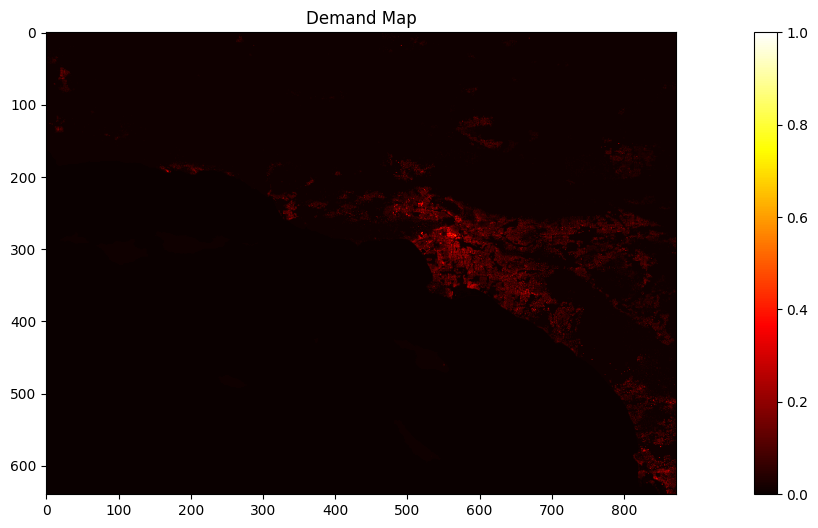

/home/limingl/wildfire/CA_model/Output_10/Fire_map/Fire_2000.csv
/home/limingl/wildfire/CA_model/Output_10/Historical_Land_Use/Historical_land_2001.csv
Step 1: Number of different positions historical--predict: 403
Step 1: Number of different positions predict--historical: 1085


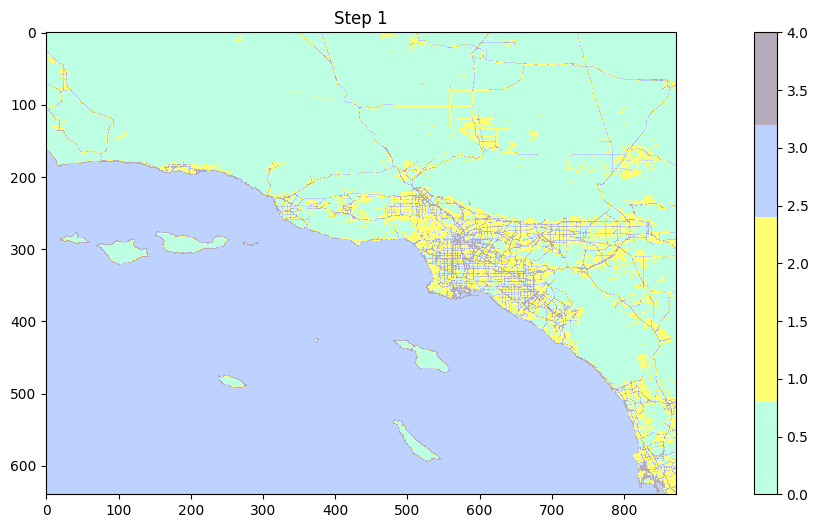

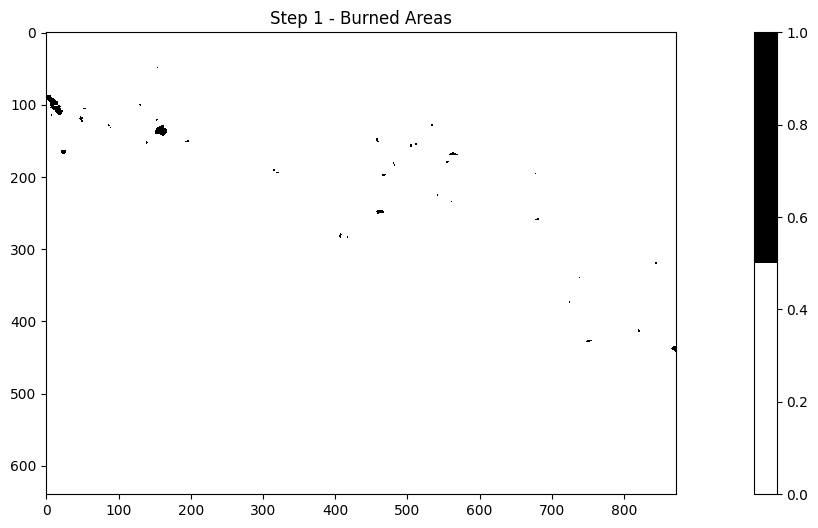

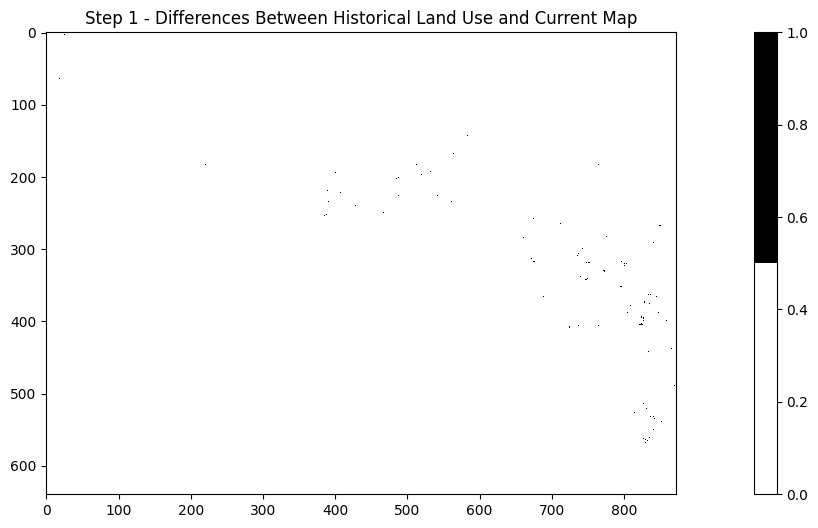

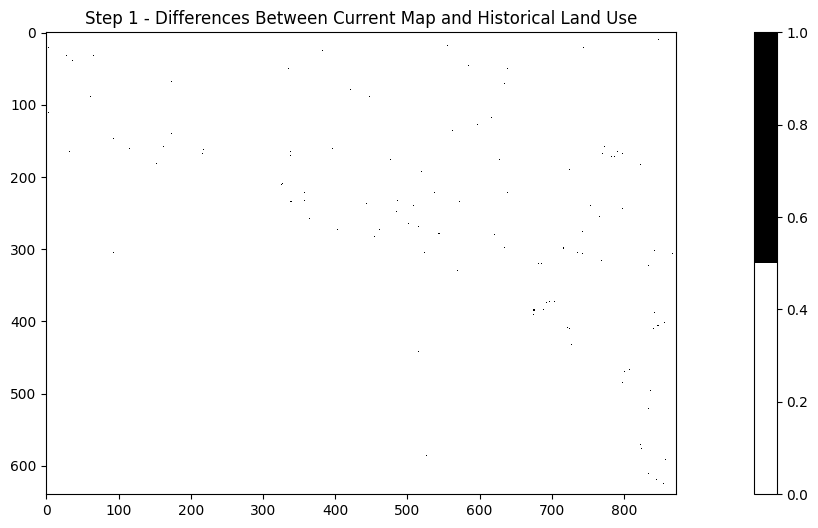

/home/limingl/wildfire/CA_model/Output_10/Fire_map/Fire_2001.csv
/home/limingl/wildfire/CA_model/Output_10/Historical_Land_Use/Historical_land_2002.csv
Step 2: Number of different positions historical--predict: 859
Step 2: Number of different positions predict--historical: 2118


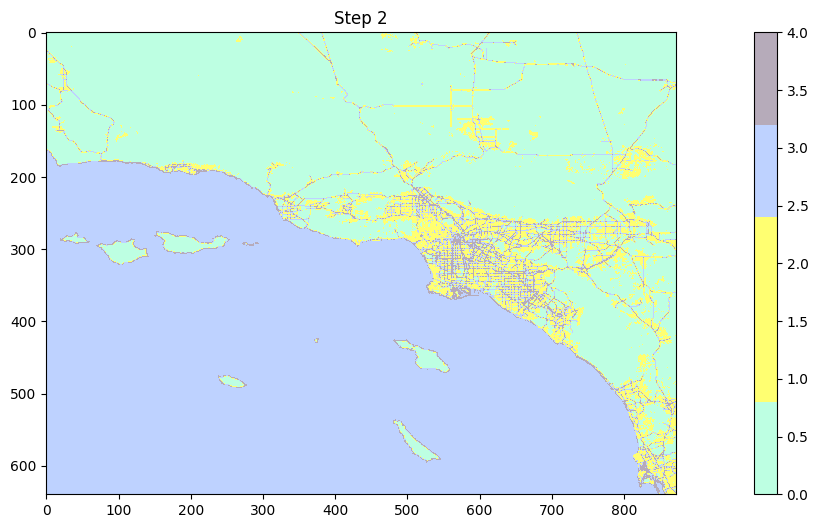

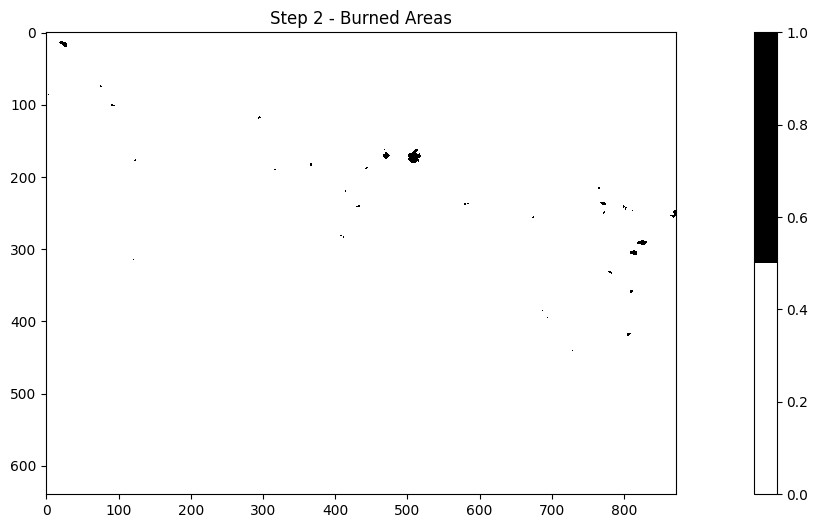

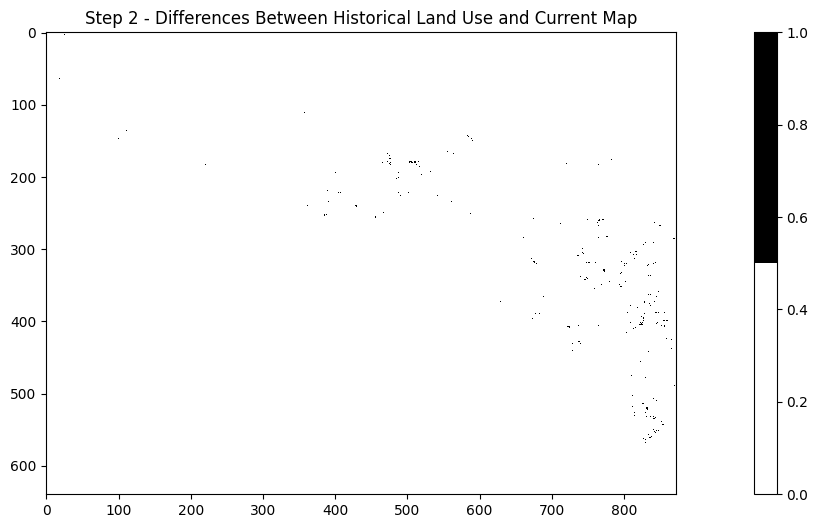

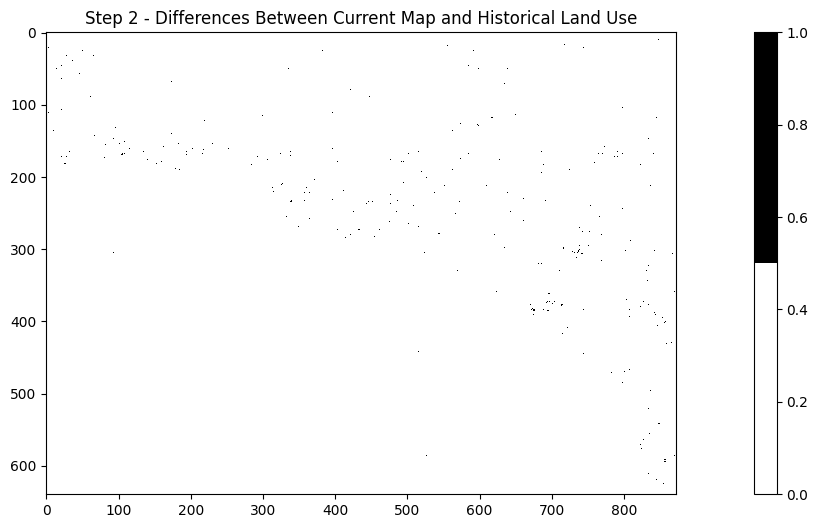

/home/limingl/wildfire/CA_model/Output_10/Fire_map/Fire_2002.csv
/home/limingl/wildfire/CA_model/Output_10/Historical_Land_Use/Historical_land_2003.csv
Step 3: Number of different positions historical--predict: 1375
Step 3: Number of different positions predict--historical: 3074


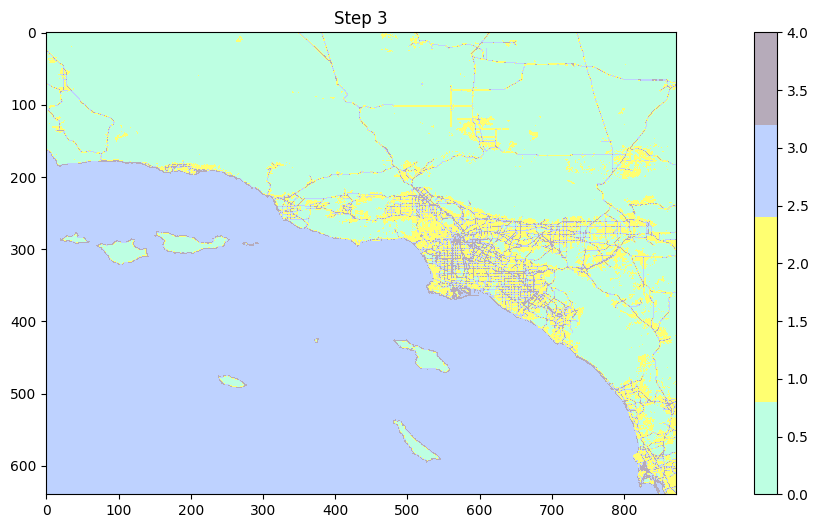

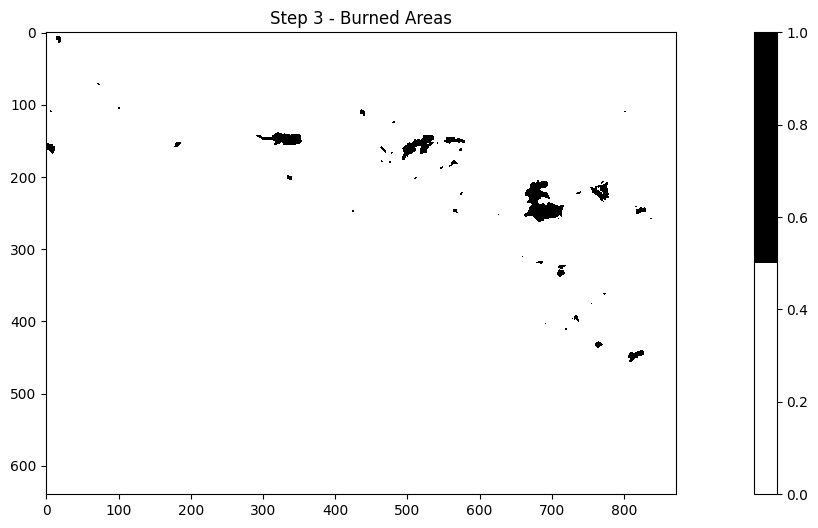

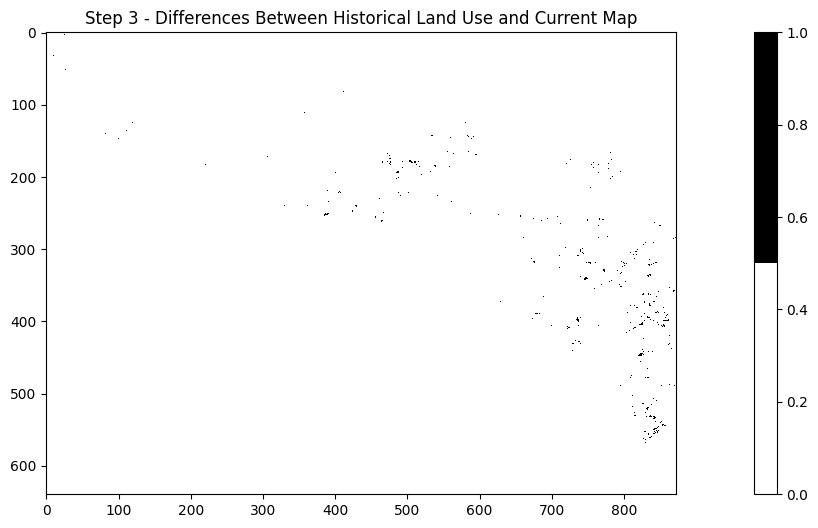

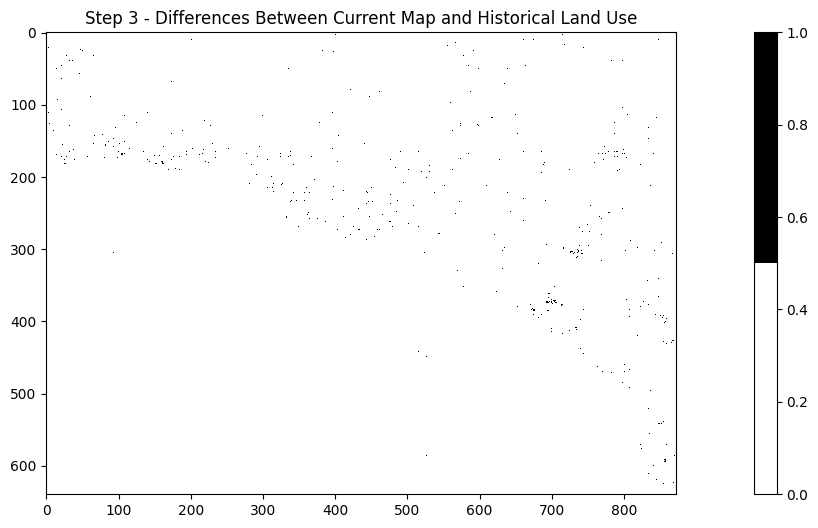

/home/limingl/wildfire/CA_model/Output_10/Fire_map/Fire_2003.csv
/home/limingl/wildfire/CA_model/Output_10/Historical_Land_Use/Historical_land_2004.csv
Step 4: Number of different positions historical--predict: 2286
Step 4: Number of different positions predict--historical: 3829


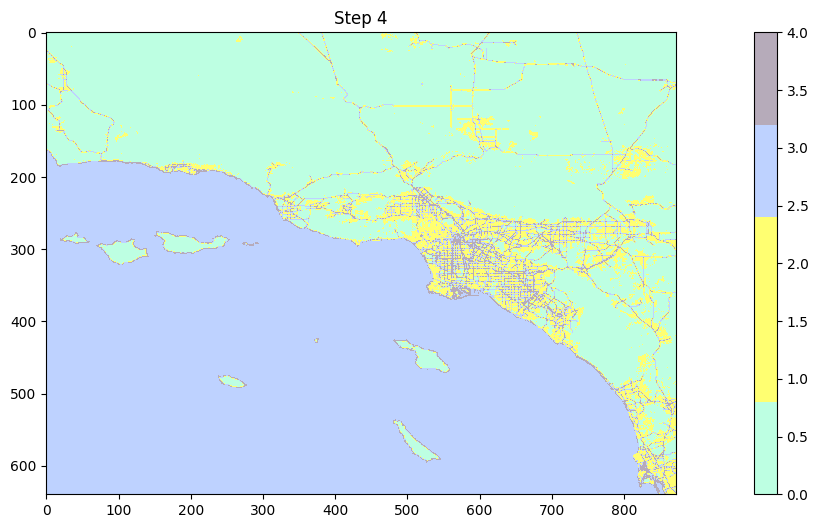

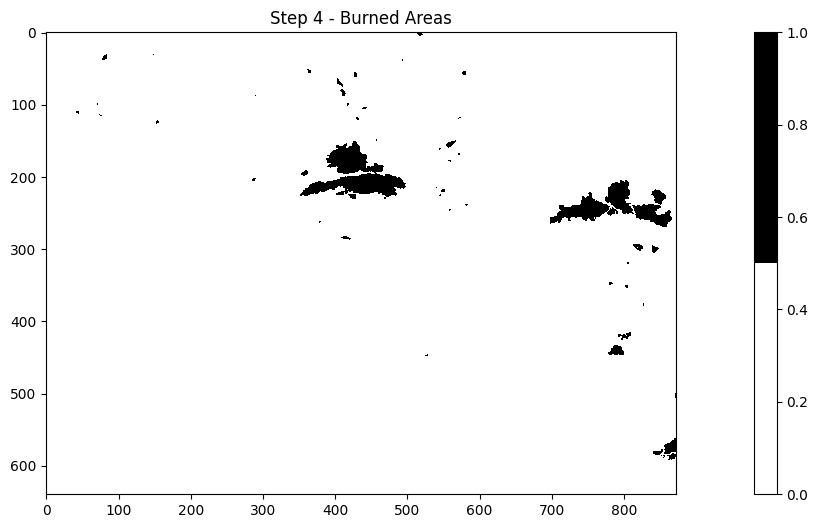

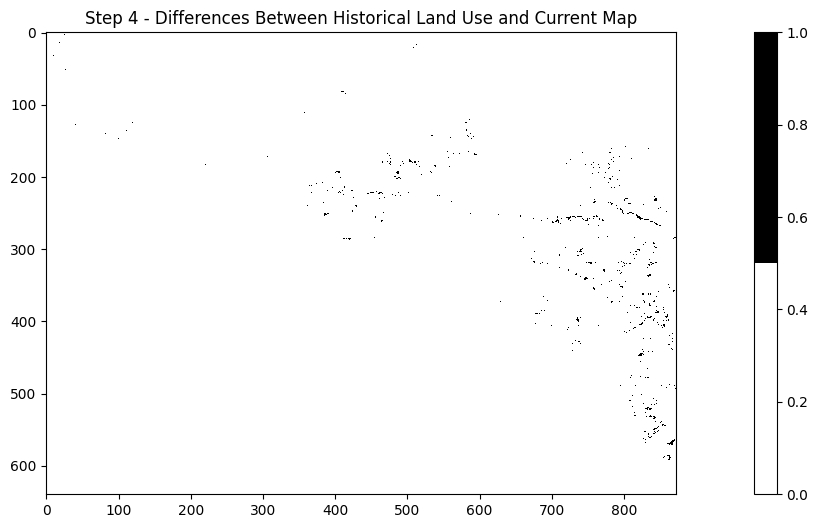

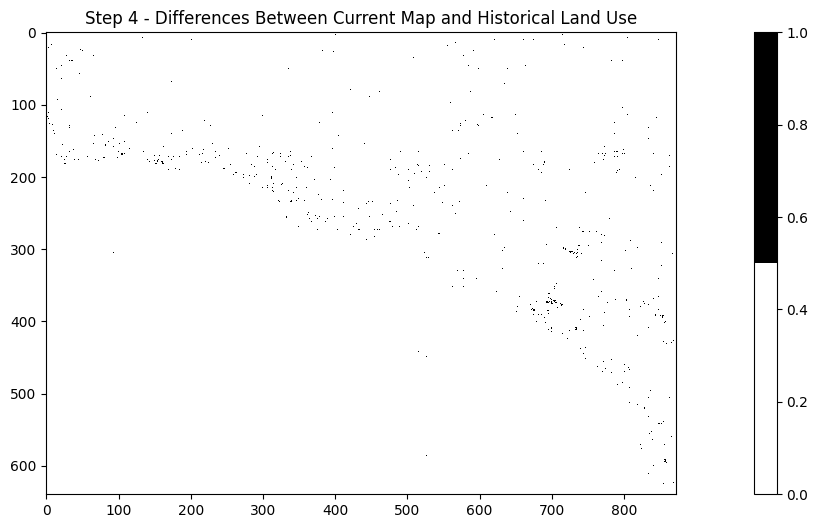

/home/limingl/wildfire/CA_model/Output_10/Fire_map/Fire_2004.csv
/home/limingl/wildfire/CA_model/Output_10/Historical_Land_Use/Historical_land_2005.csv
Step 5: Number of different positions historical--predict: 2779
Step 5: Number of different positions predict--historical: 4628


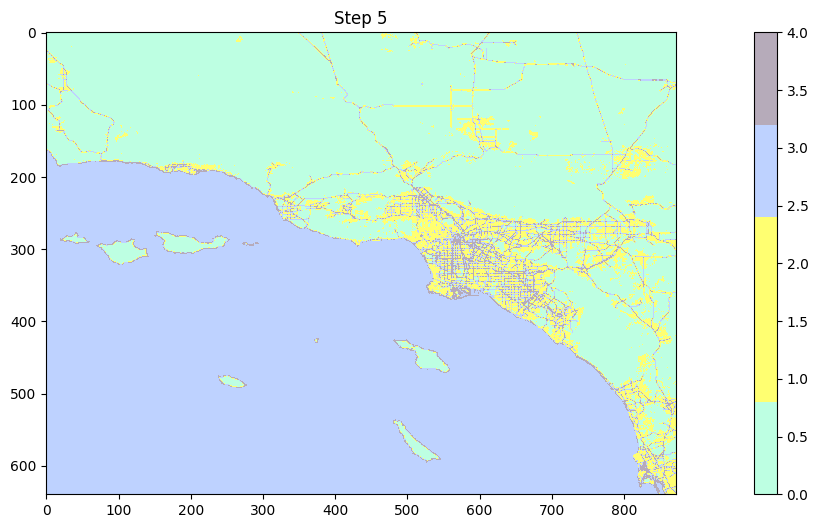

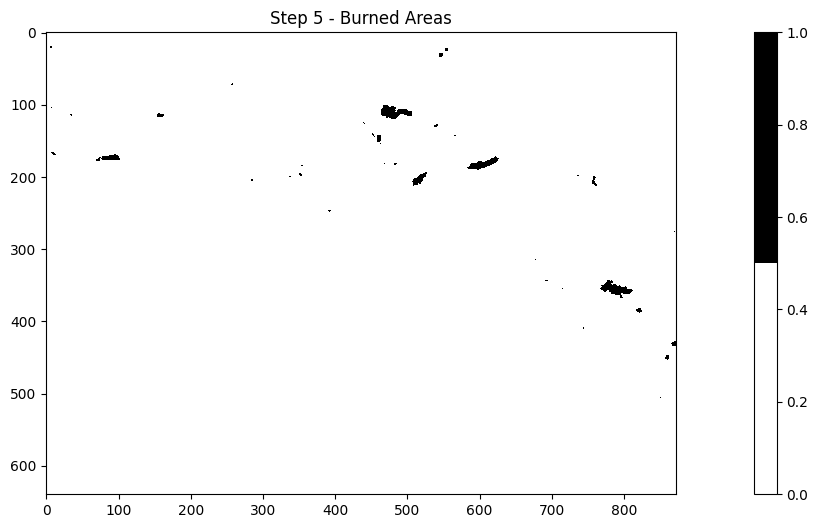

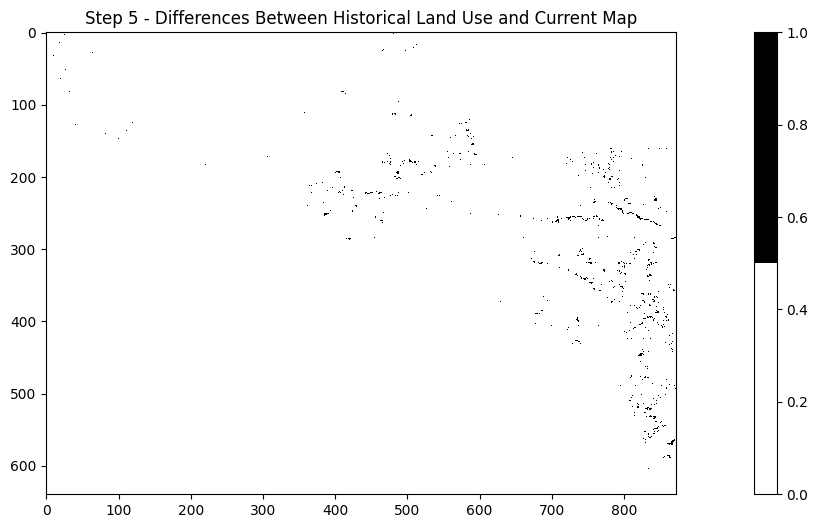

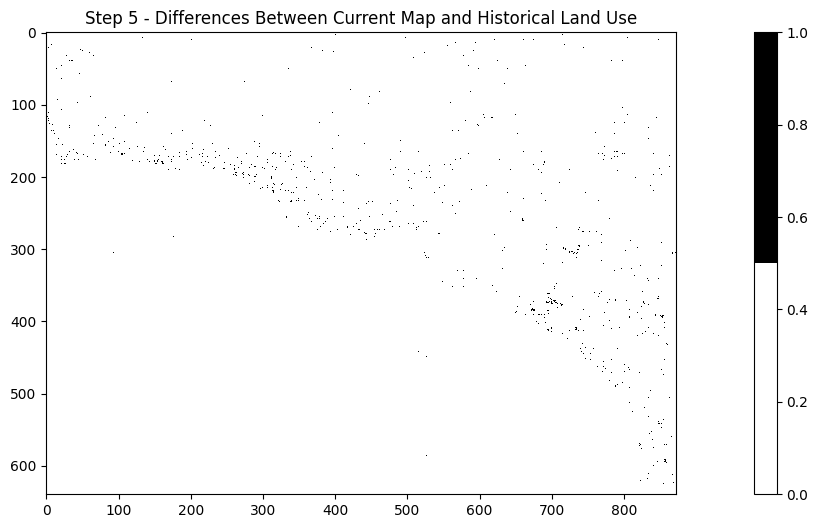

/home/limingl/wildfire/CA_model/Output_10/Fire_map/Fire_2005.csv
/home/limingl/wildfire/CA_model/Output_10/Historical_Land_Use/Historical_land_2006.csv
Step 6: Number of different positions historical--predict: 3320
Step 6: Number of different positions predict--historical: 5404


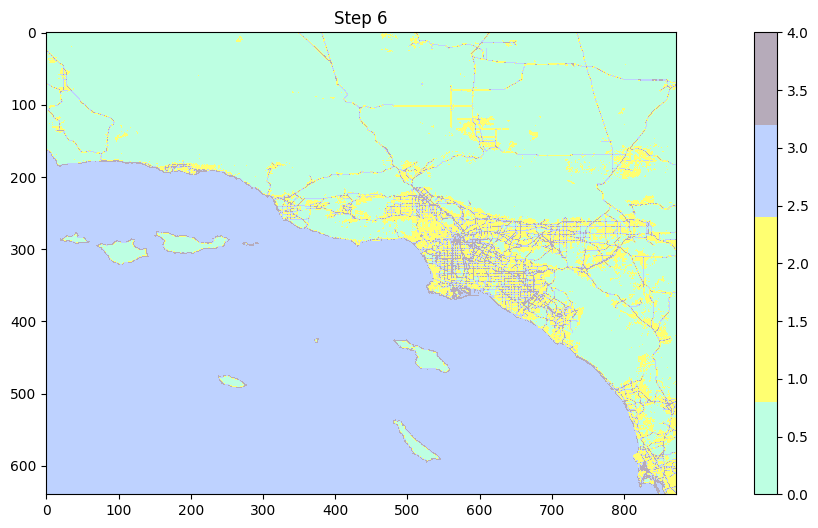

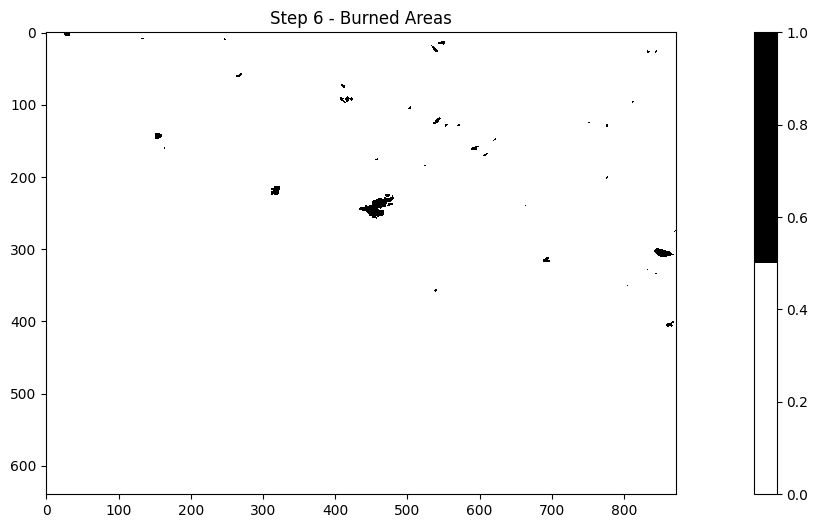

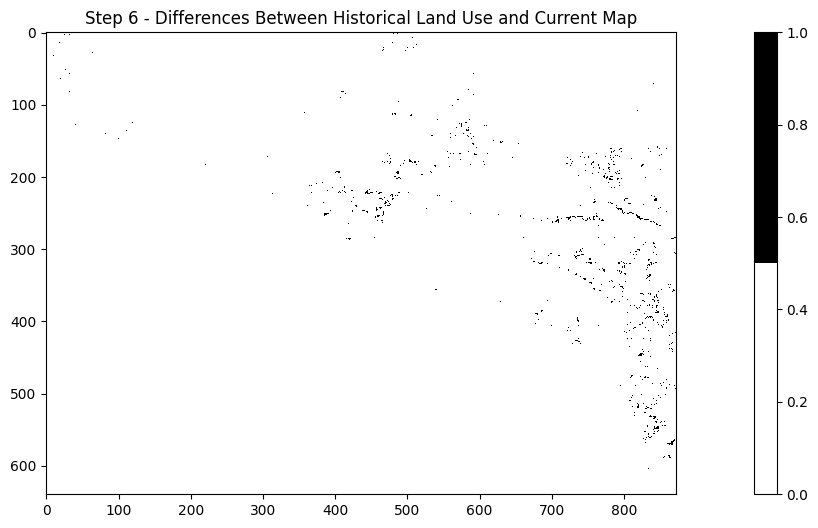

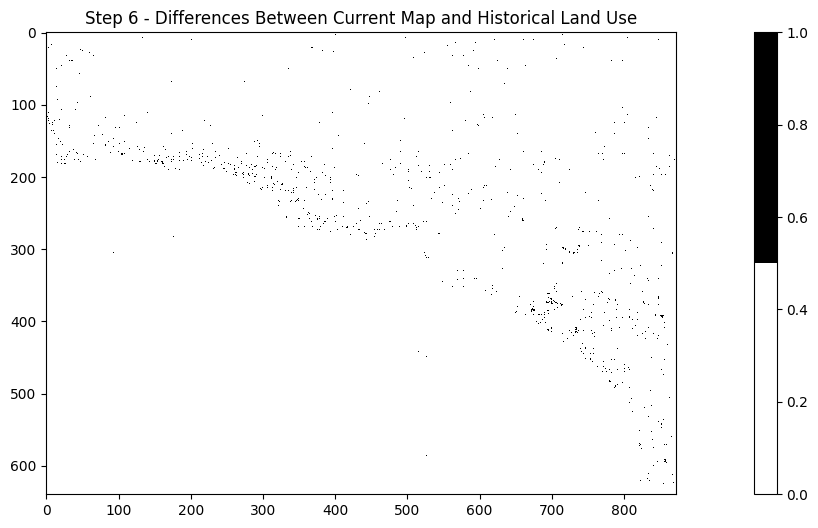

/home/limingl/wildfire/CA_model/Output_10/Fire_map/Fire_2006.csv
/home/limingl/wildfire/CA_model/Output_10/Historical_Land_Use/Historical_land_2007.csv
Step 7: Number of different positions historical--predict: 3579
Step 7: Number of different positions predict--historical: 6197


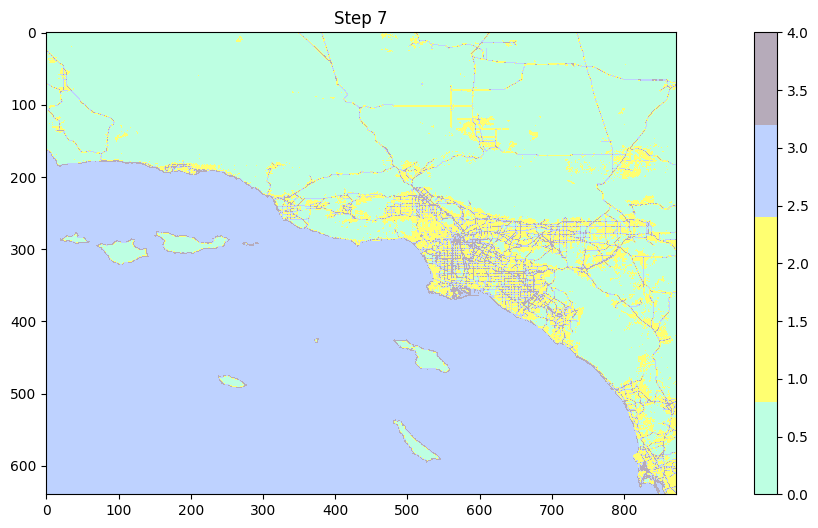

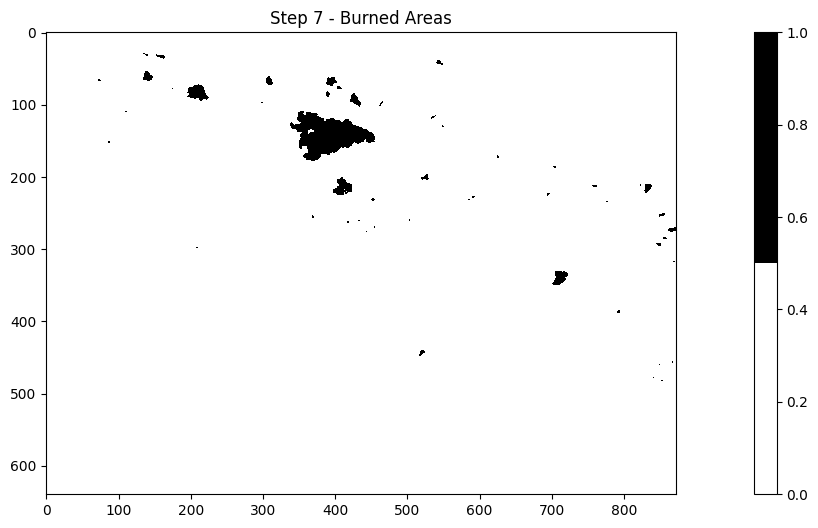

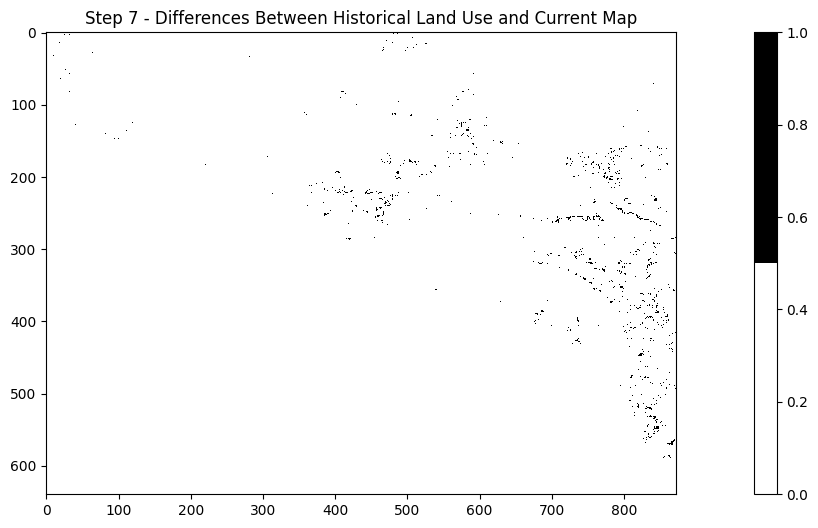

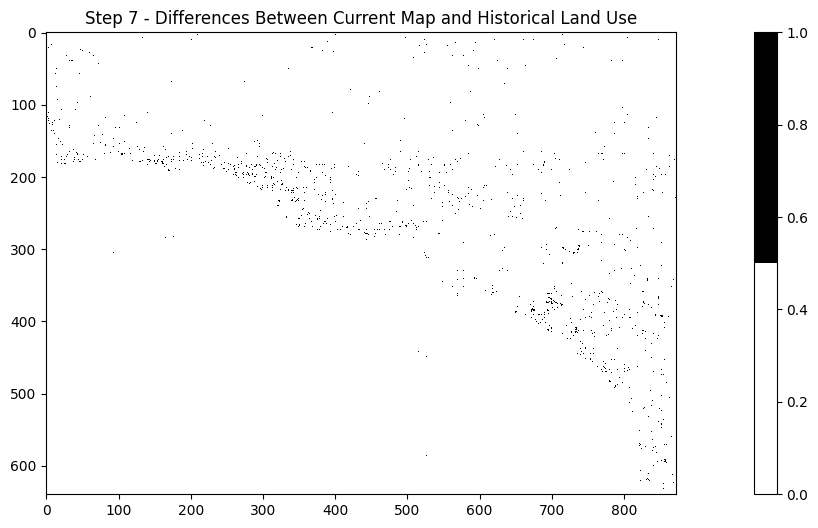

/home/limingl/wildfire/CA_model/Output_10/Fire_map/Fire_2007.csv
/home/limingl/wildfire/CA_model/Output_10/Historical_Land_Use/Historical_land_2008.csv
Step 8: Number of different positions historical--predict: 4165
Step 8: Number of different positions predict--historical: 6802


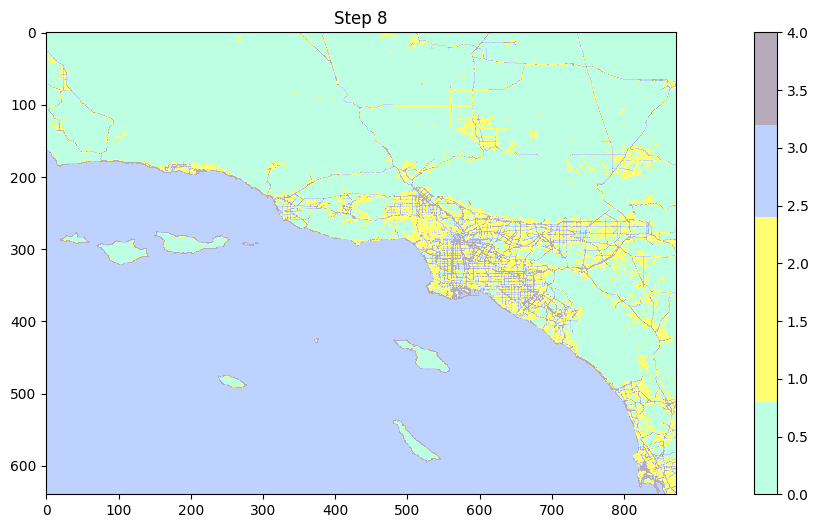

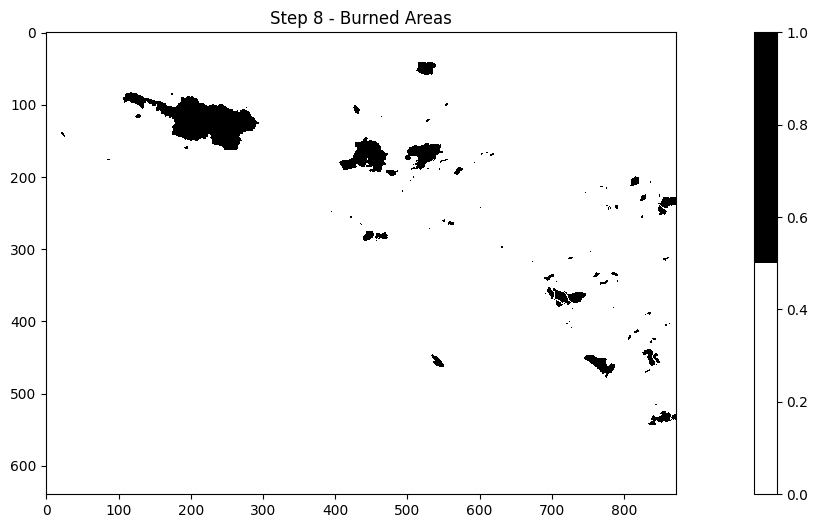

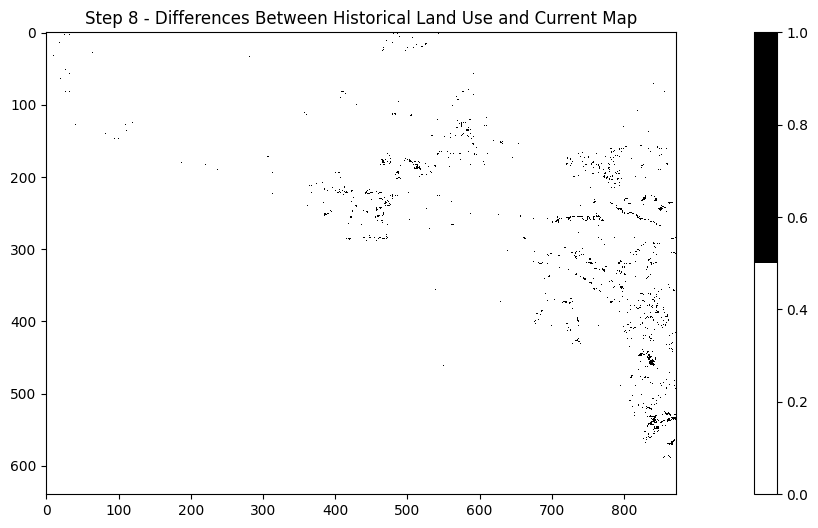

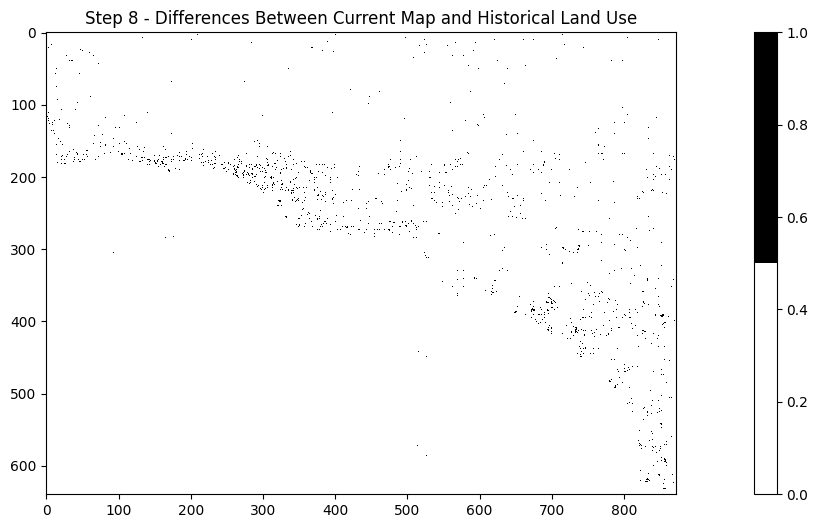

/home/limingl/wildfire/CA_model/Output_10/Fire_map/Fire_2008.csv
/home/limingl/wildfire/CA_model/Output_10/Historical_Land_Use/Historical_land_2009.csv
Step 9: Number of different positions historical--predict: 4367
Step 9: Number of different positions predict--historical: 7591


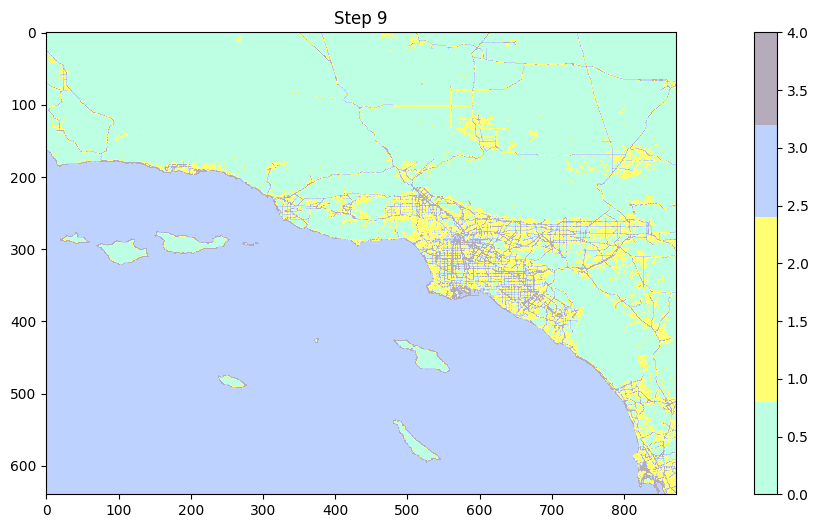

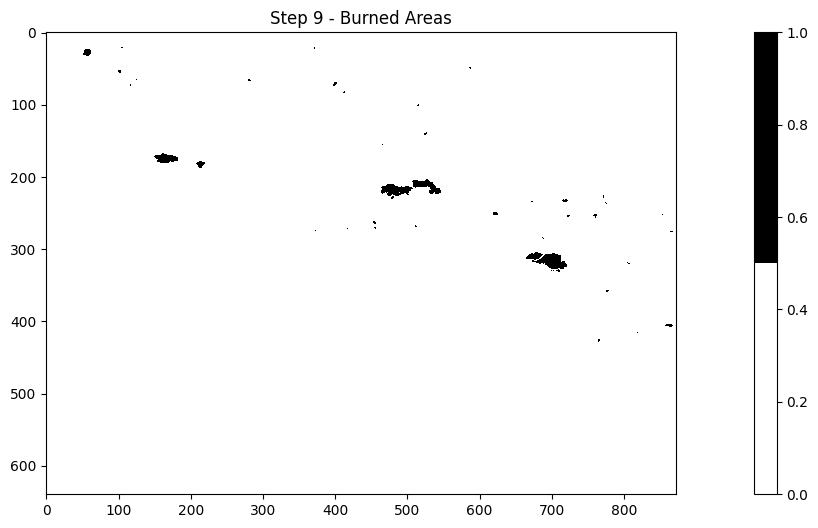

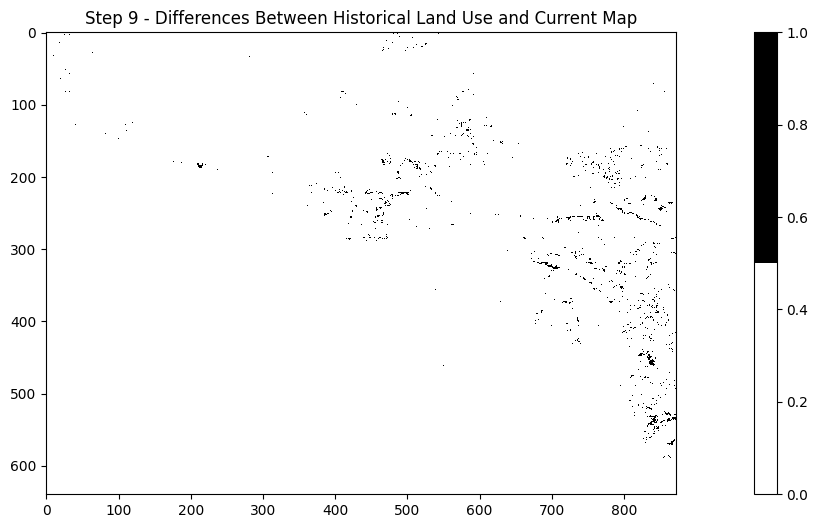

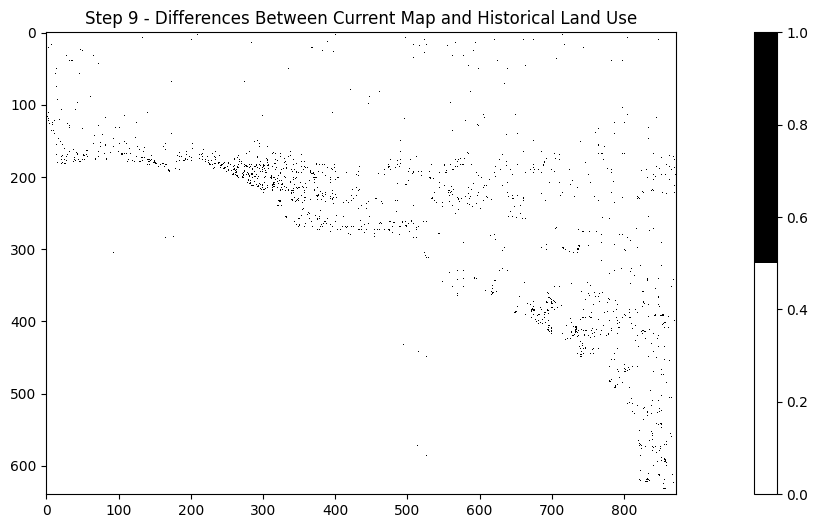

/home/limingl/wildfire/CA_model/Output_10/Fire_map/Fire_2009.csv
/home/limingl/wildfire/CA_model/Output_10/Historical_Land_Use/Historical_land_2010.csv
Step 10: Number of different positions historical--predict: 4393
Step 10: Number of different positions predict--historical: 8130


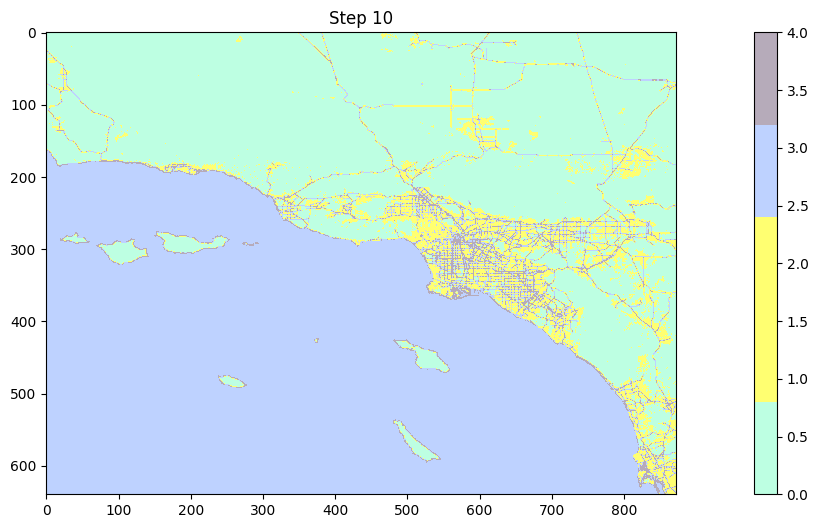

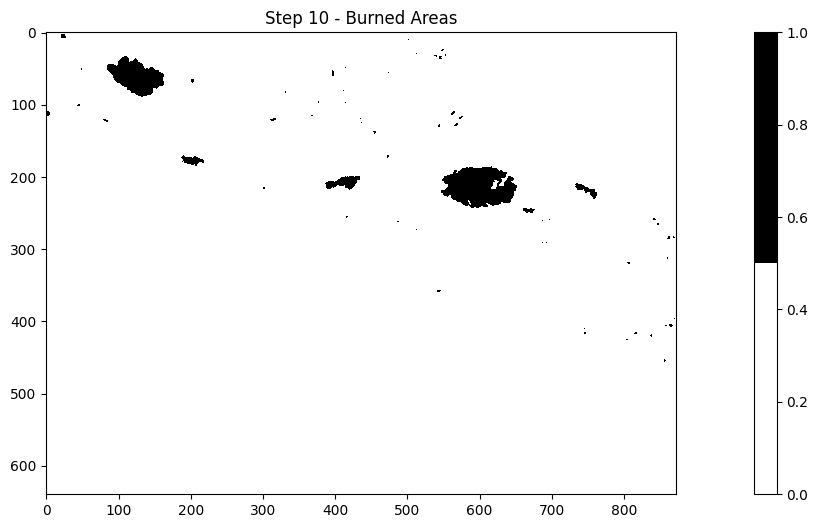

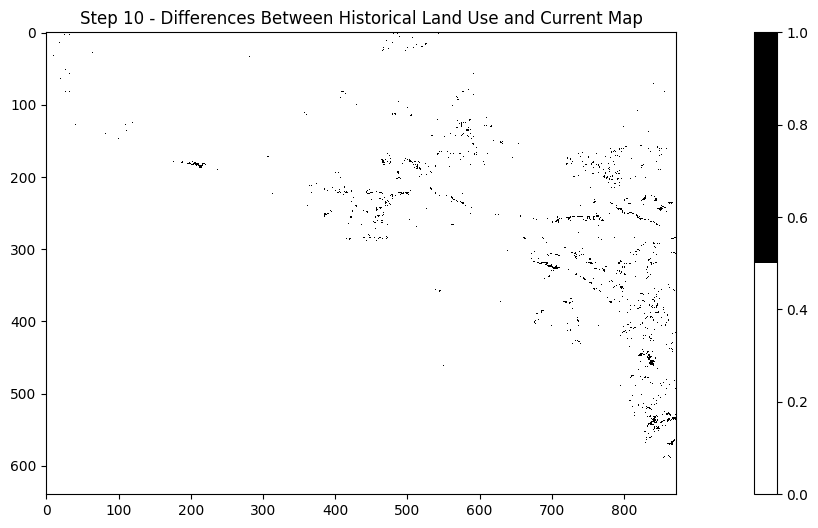

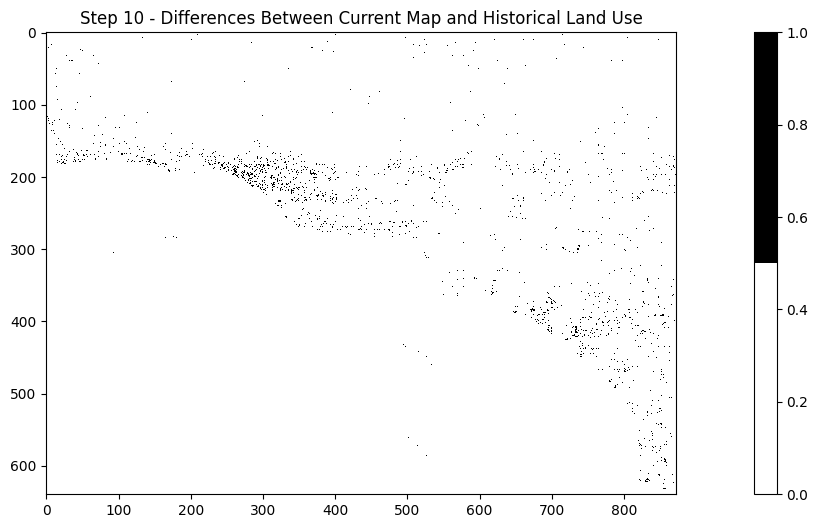

/home/limingl/wildfire/CA_model/Output_10/Fire_map/Fire_2010.csv
/home/limingl/wildfire/CA_model/Output_10/Historical_Land_Use/Historical_land_2011.csv
Step 11: Number of different positions historical--predict: 4402
Step 11: Number of different positions predict--historical: 9030


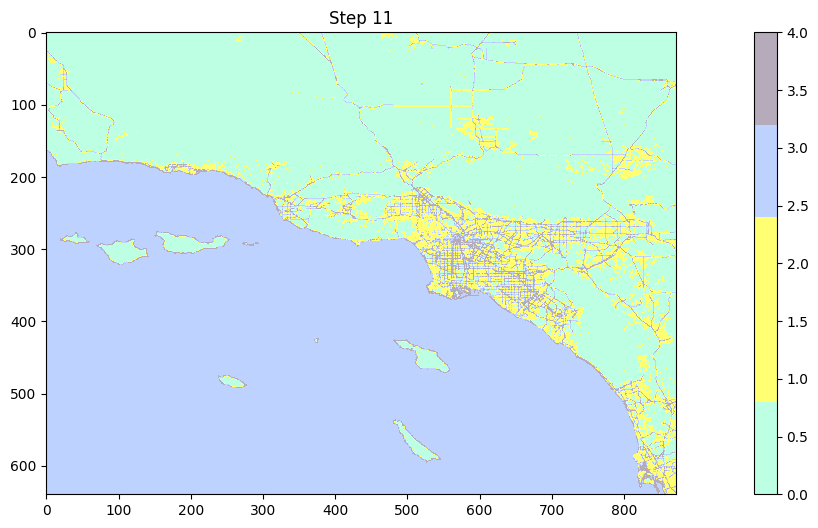

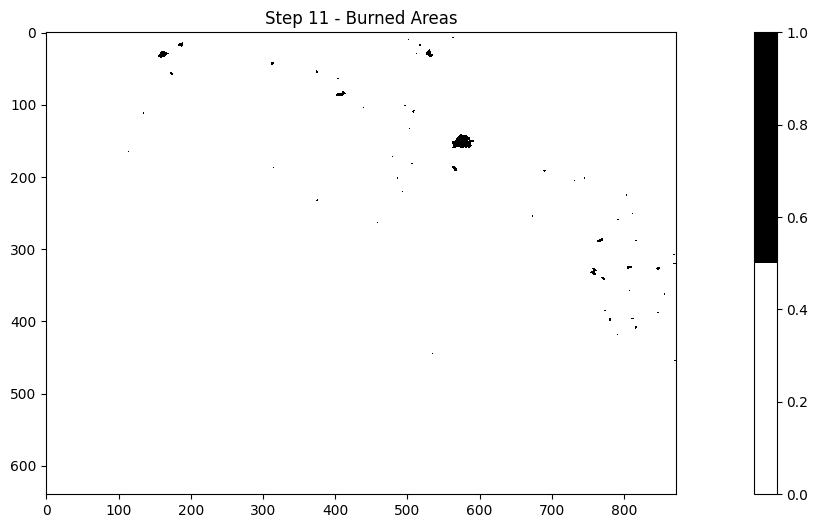

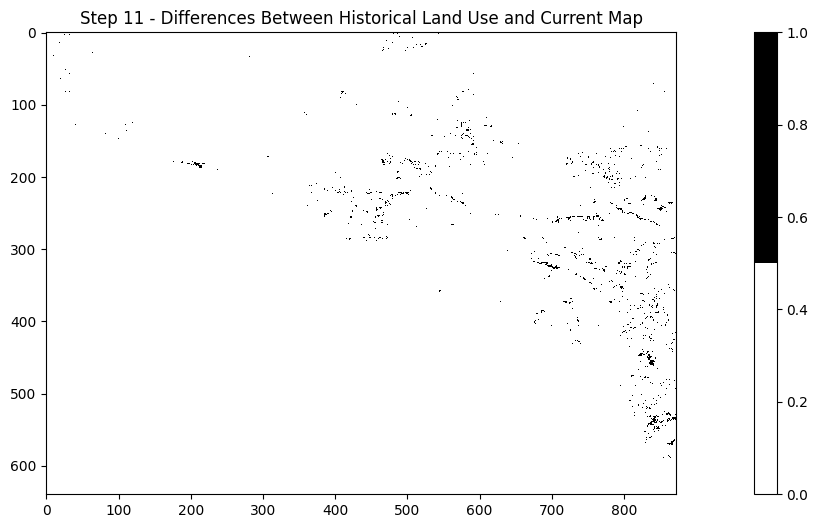

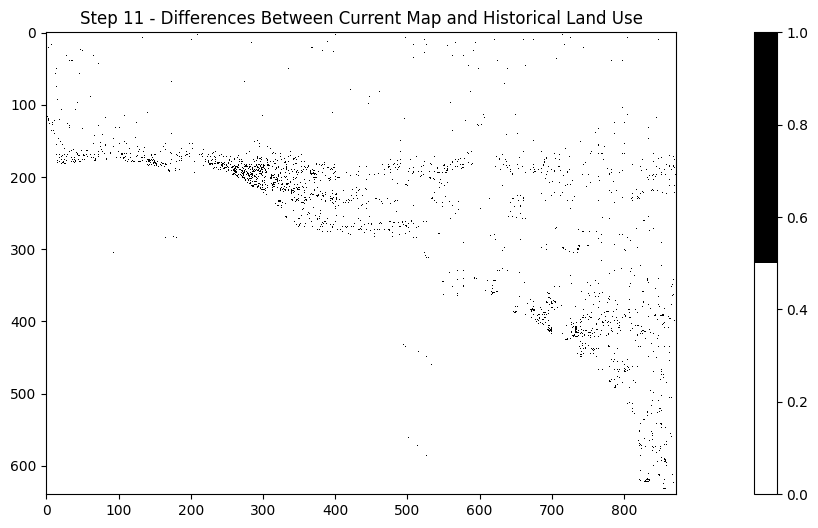

/home/limingl/wildfire/CA_model/Output_10/Fire_map/Fire_2011.csv
/home/limingl/wildfire/CA_model/Output_10/Historical_Land_Use/Historical_land_2012.csv
Step 12: Number of different positions historical--predict: 4355
Step 12: Number of different positions predict--historical: 9926


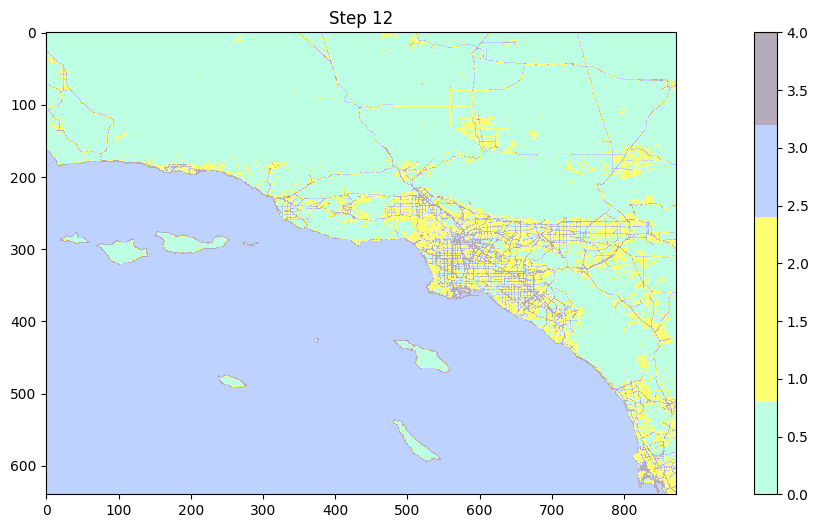

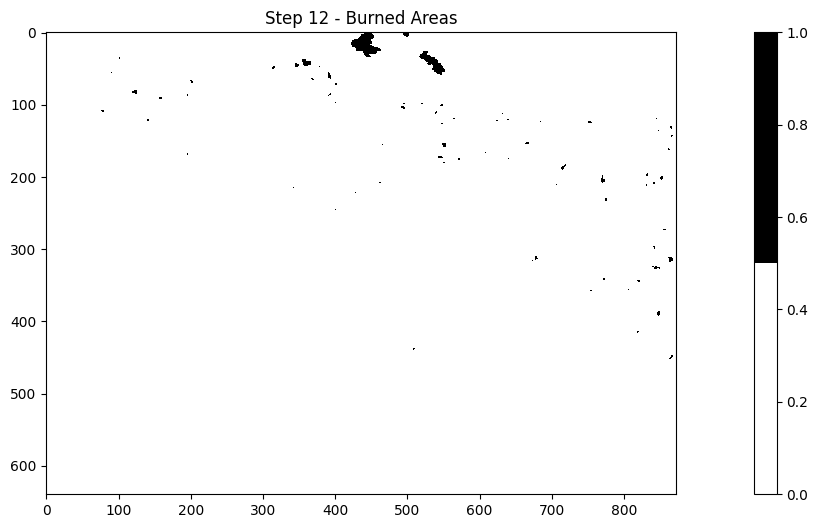

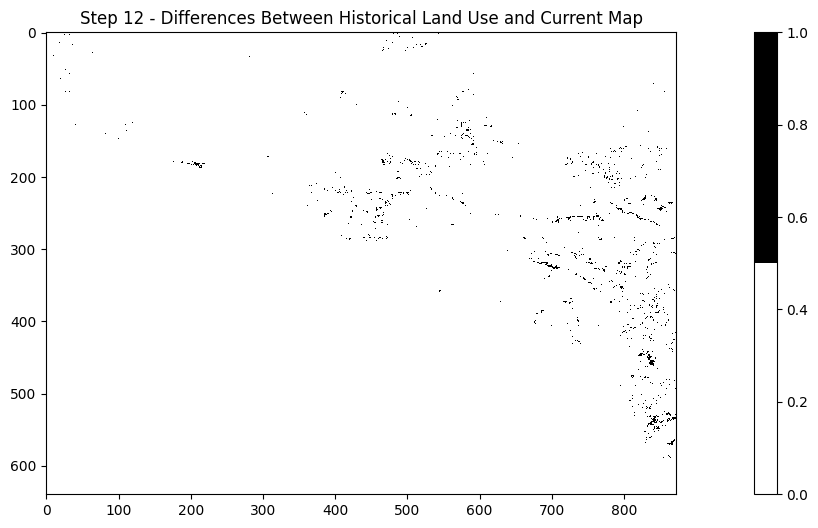

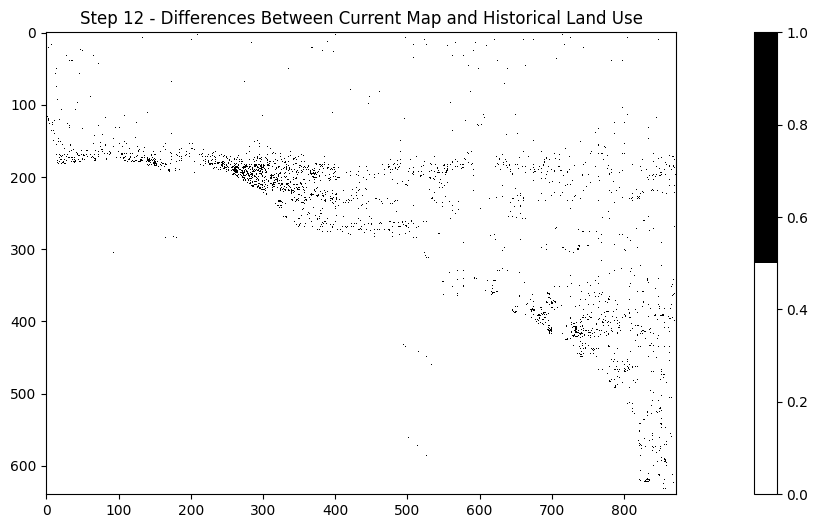

/home/limingl/wildfire/CA_model/Output_10/Fire_map/Fire_2012.csv
/home/limingl/wildfire/CA_model/Output_10/Historical_Land_Use/Historical_land_2013.csv
Step 13: Number of different positions historical--predict: 4338
Step 13: Number of different positions predict--historical: 10817


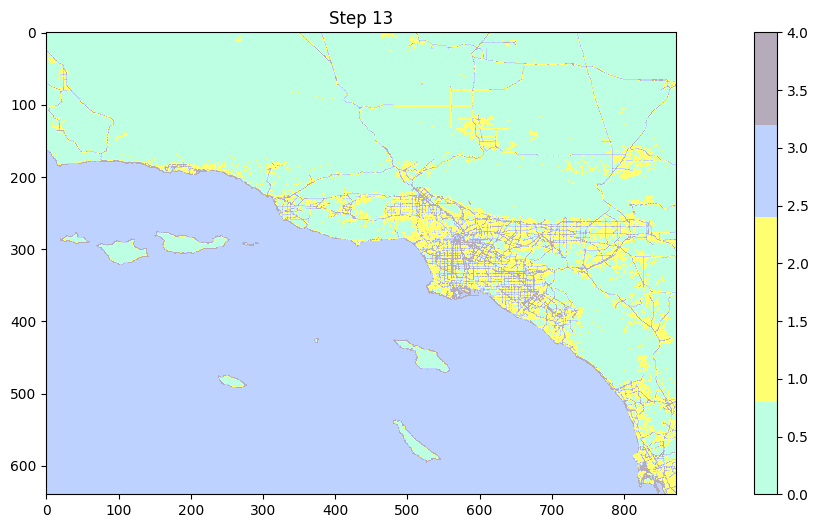

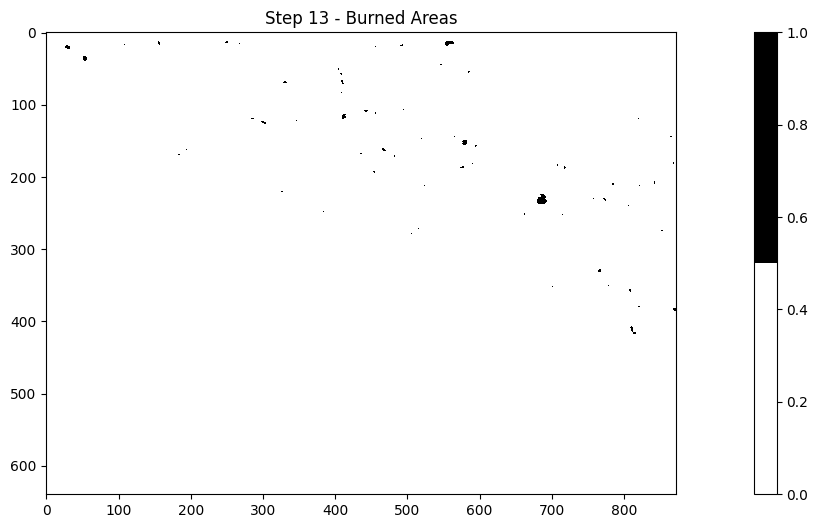

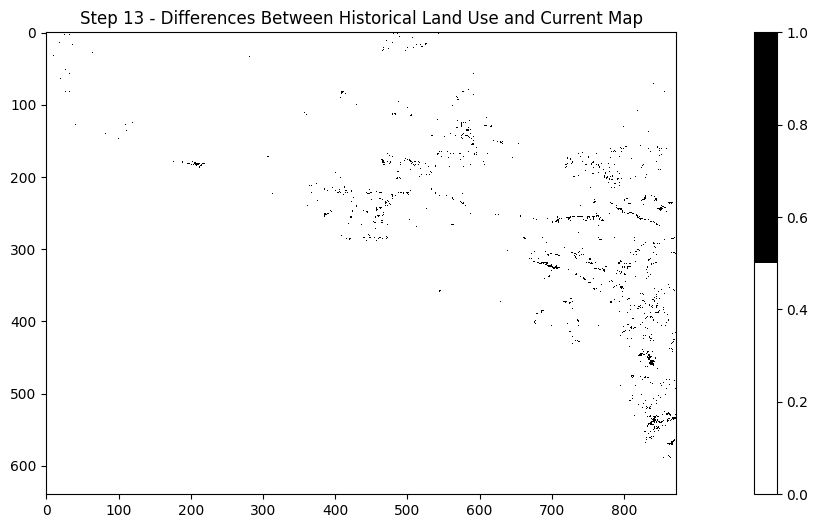

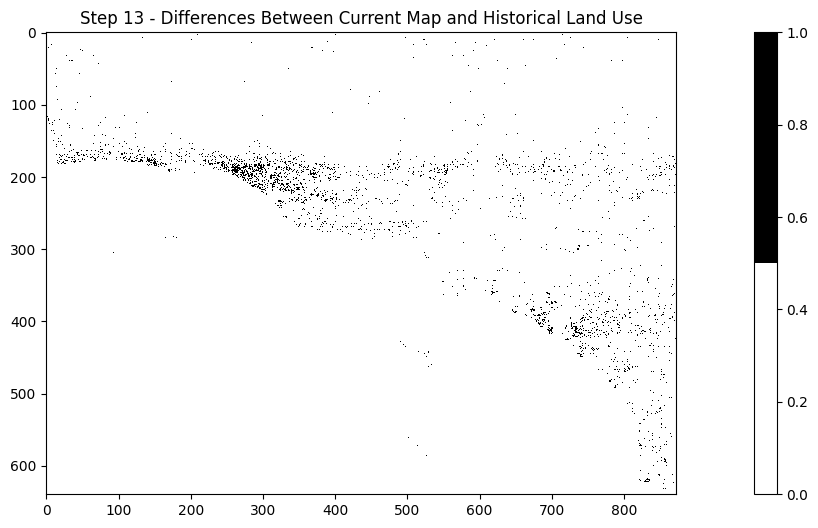

/home/limingl/wildfire/CA_model/Output_10/Fire_map/Fire_2013.csv
/home/limingl/wildfire/CA_model/Output_10/Historical_Land_Use/Historical_land_2014.csv
Step 14: Number of different positions historical--predict: 4366
Step 14: Number of different positions predict--historical: 11592


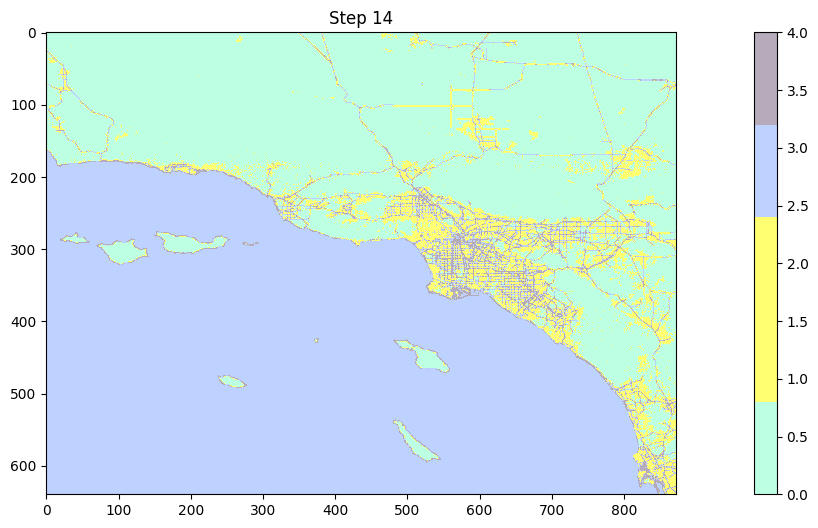

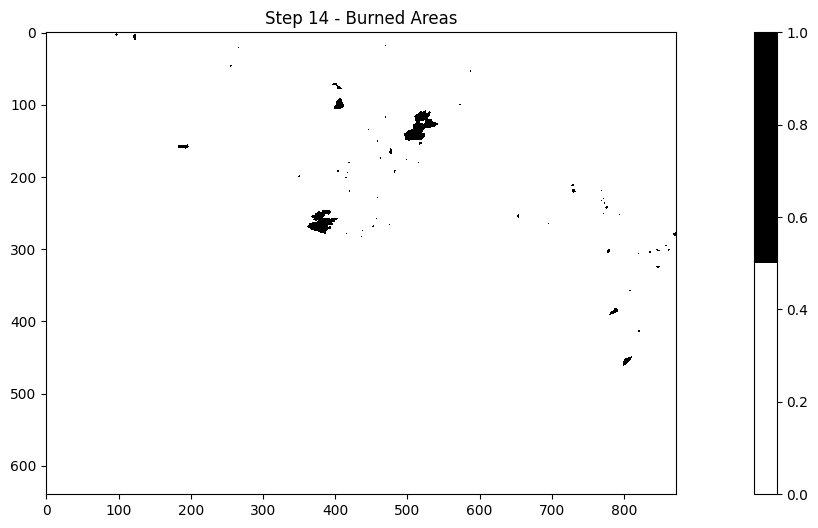

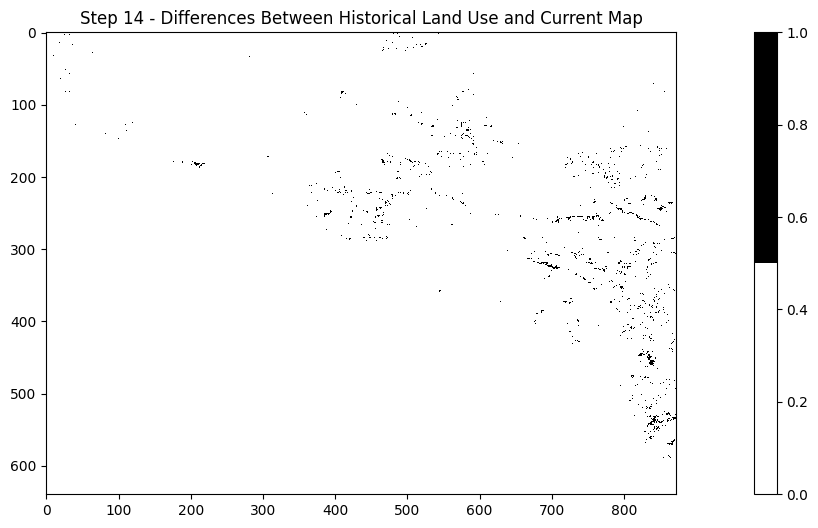

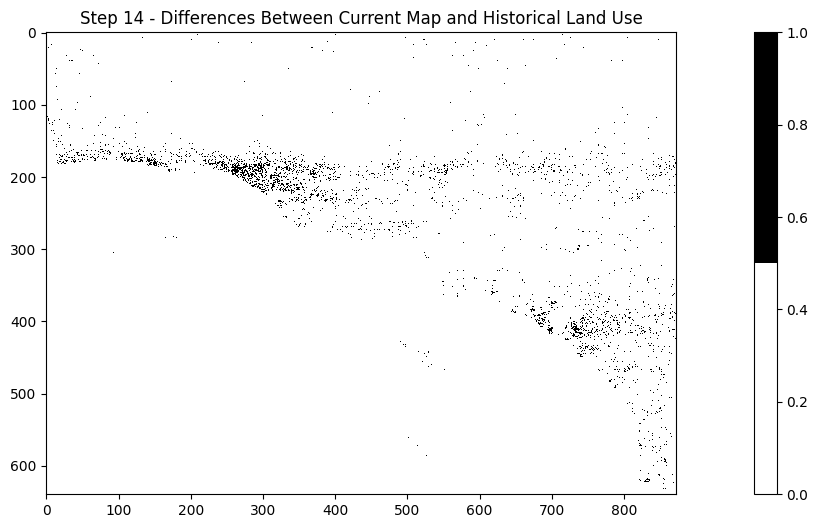

/home/limingl/wildfire/CA_model/Output_10/Fire_map/Fire_2014.csv
/home/limingl/wildfire/CA_model/Output_10/Historical_Land_Use/Historical_land_2015.csv
Step 15: Number of different positions historical--predict: 4436
Step 15: Number of different positions predict--historical: 12359


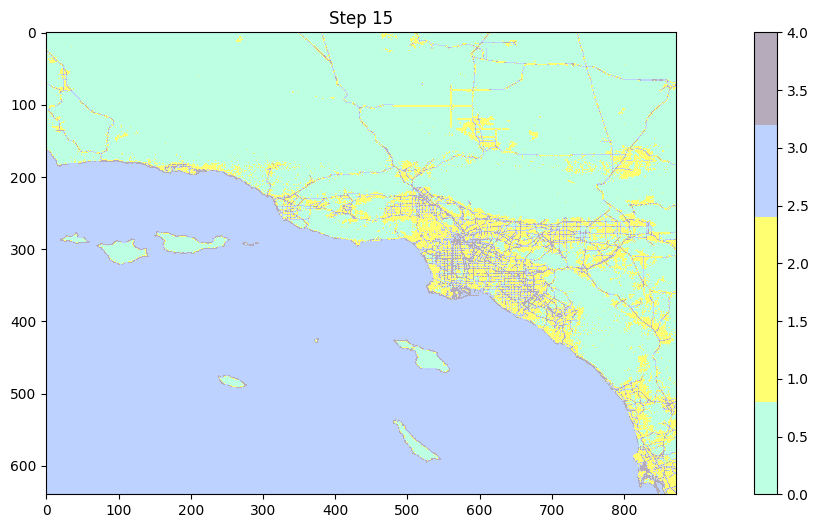

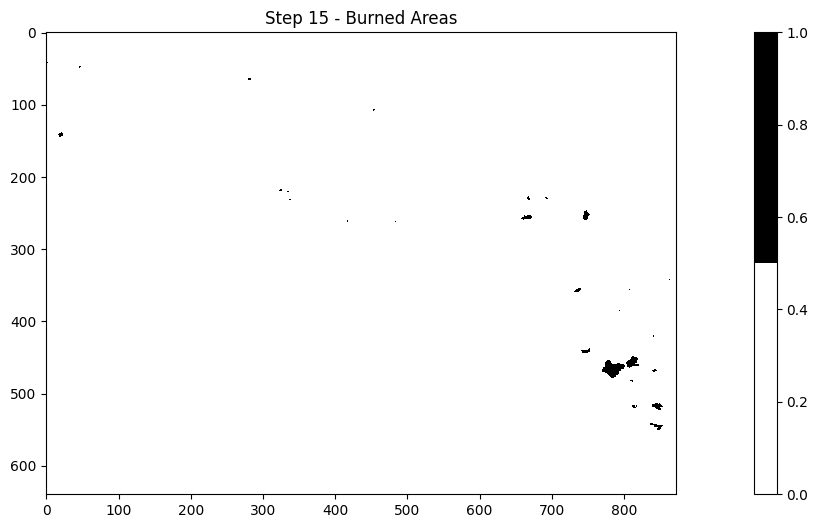

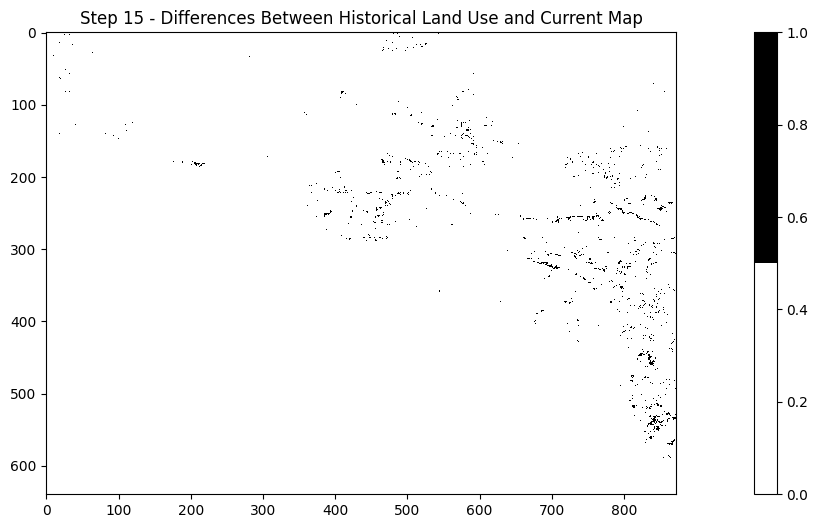

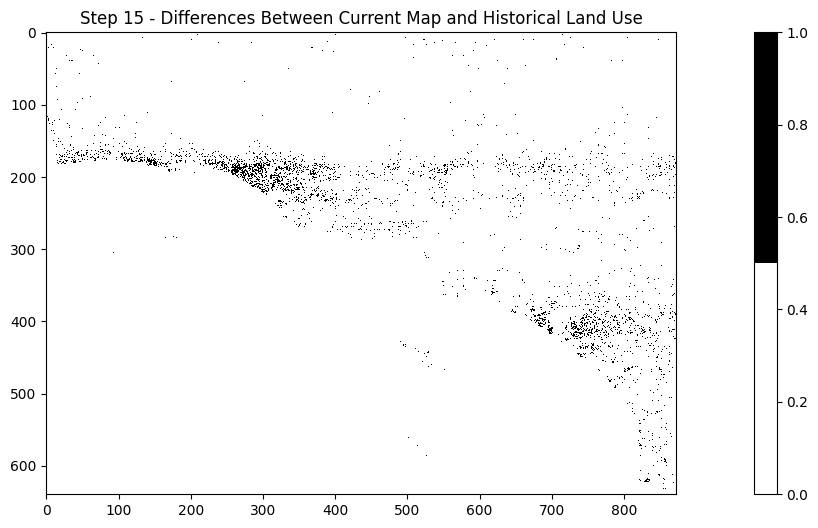

/home/limingl/wildfire/CA_model/Output_10/Fire_map/Fire_2015.csv
/home/limingl/wildfire/CA_model/Output_10/Historical_Land_Use/Historical_land_2016.csv
Step 16: Number of different positions historical--predict: 4465
Step 16: Number of different positions predict--historical: 13216


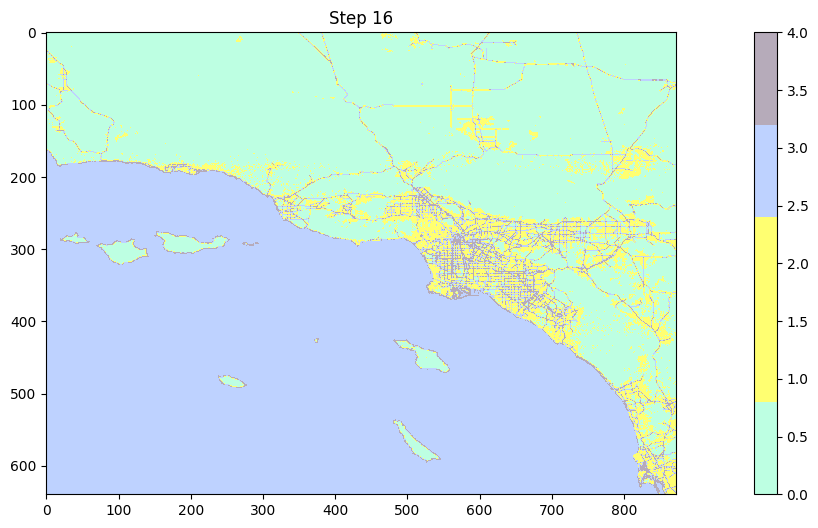

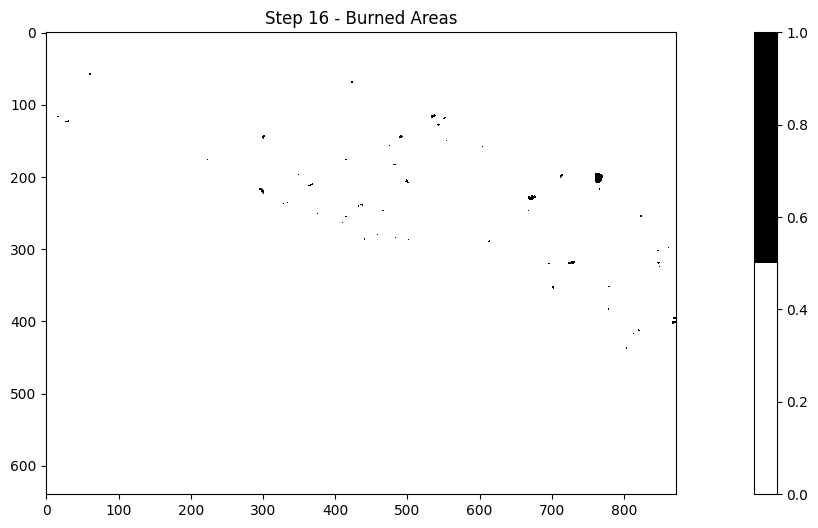

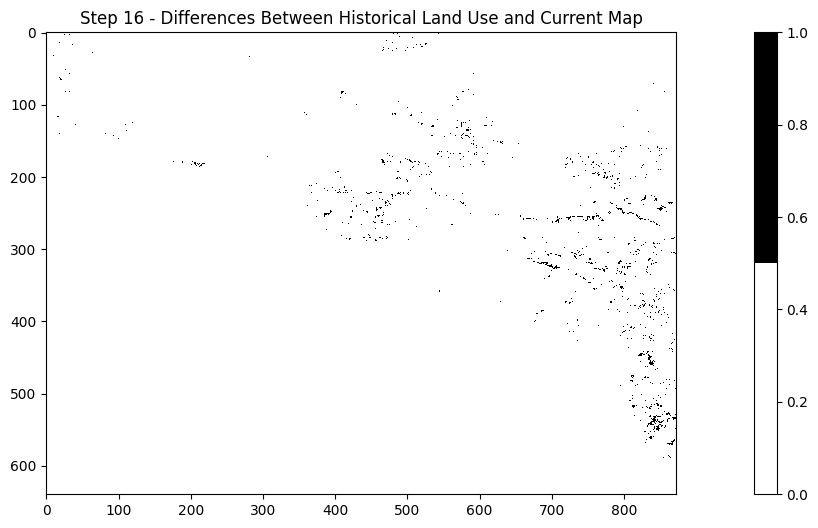

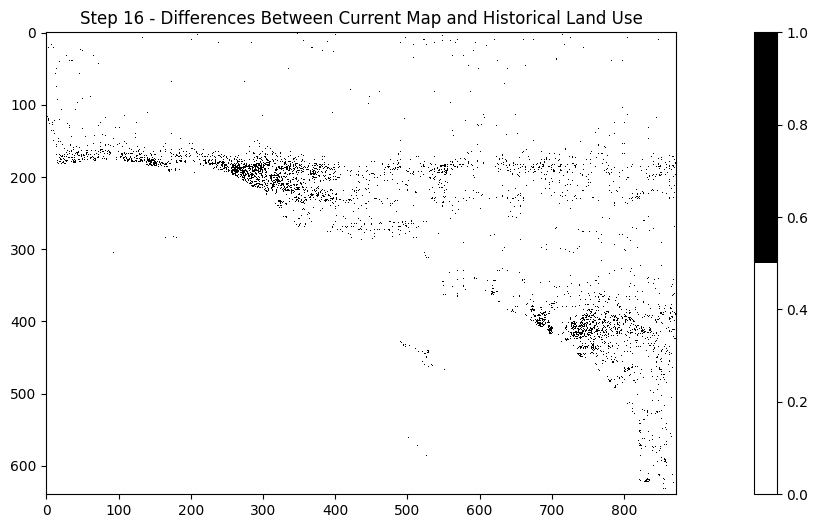

/home/limingl/wildfire/CA_model/Output_10/Fire_map/Fire_2016.csv
/home/limingl/wildfire/CA_model/Output_10/Historical_Land_Use/Historical_land_2017.csv
Step 17: Number of different positions historical--predict: 4585
Step 17: Number of different positions predict--historical: 13675


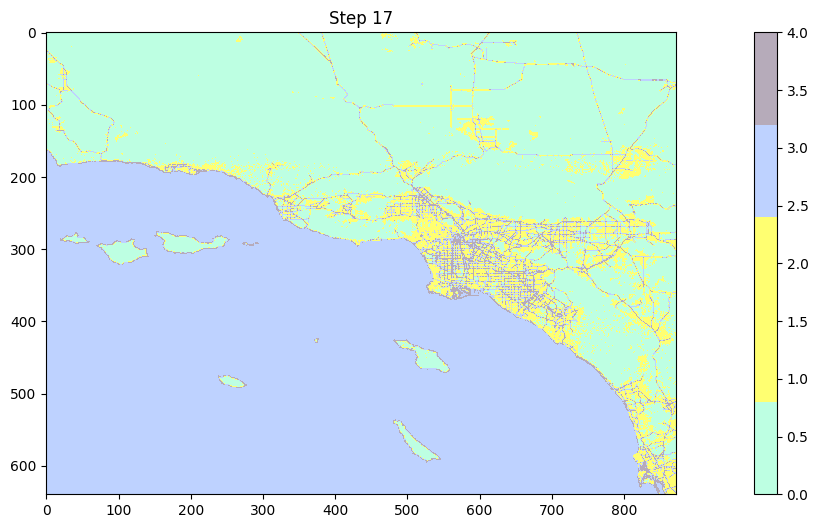

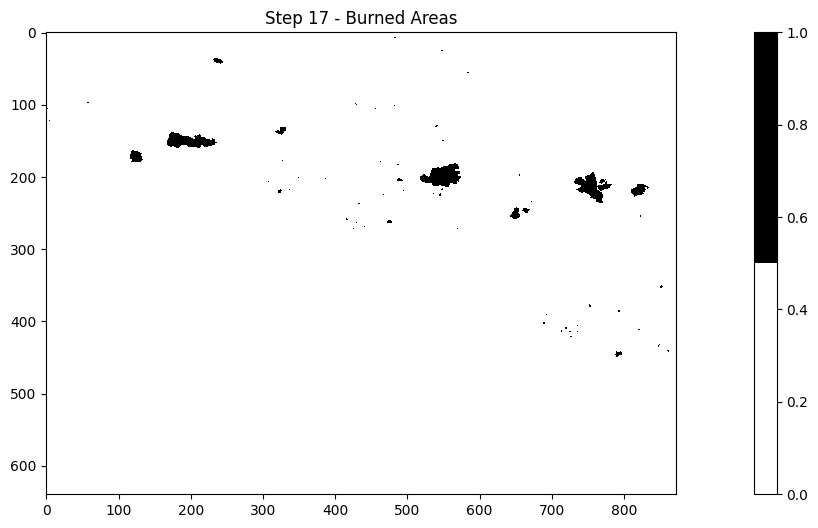

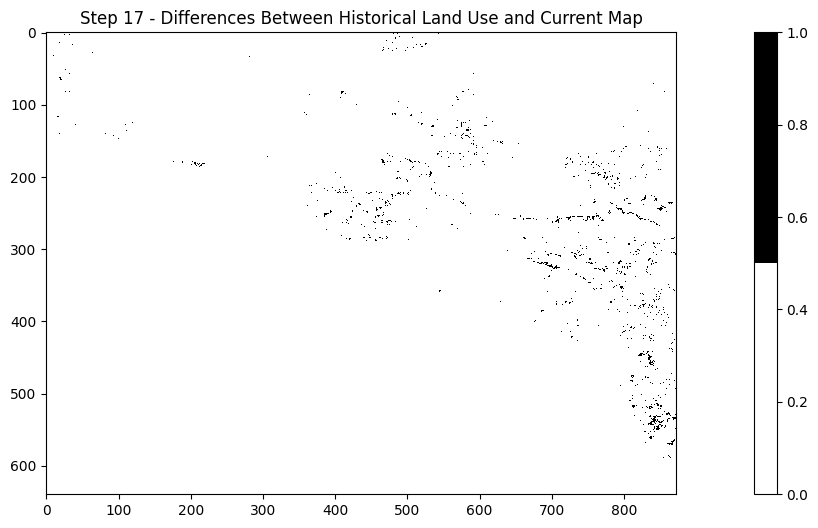

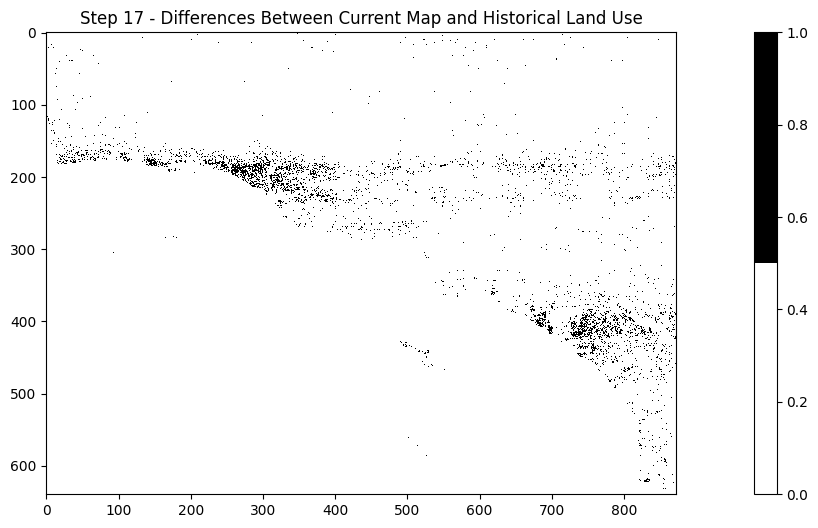

/home/limingl/wildfire/CA_model/Output_10/Fire_map/Fire_2017.csv
/home/limingl/wildfire/CA_model/Output_10/Historical_Land_Use/Historical_land_2018.csv
Step 18: Number of different positions historical--predict: 5003
Step 18: Number of different positions predict--historical: 12268


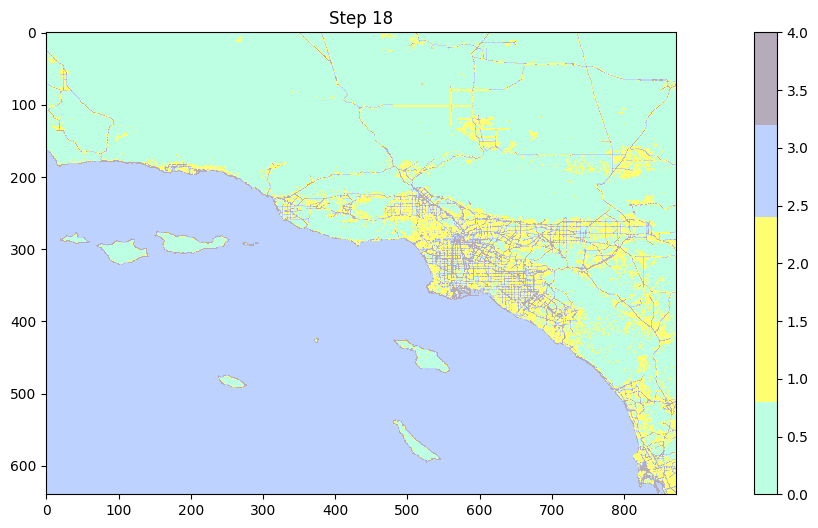

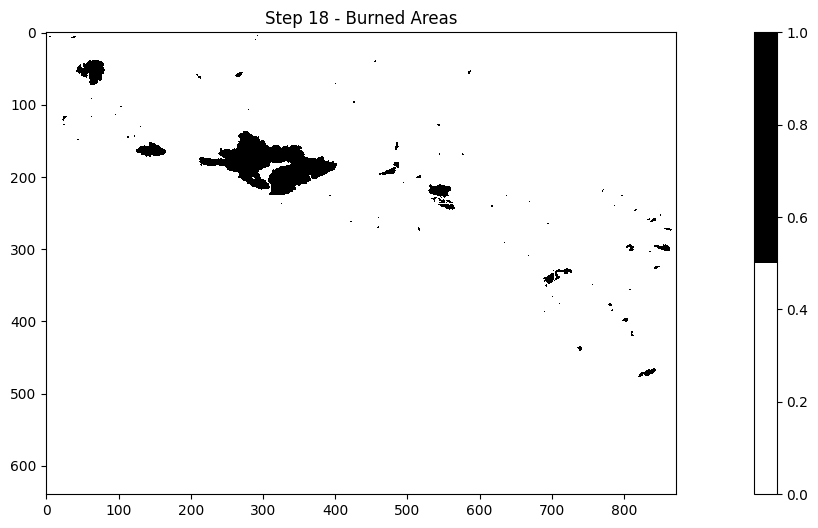

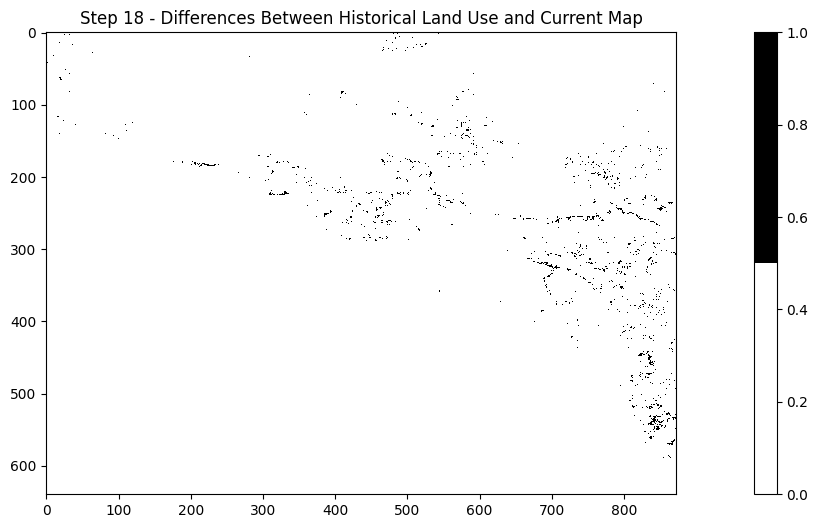

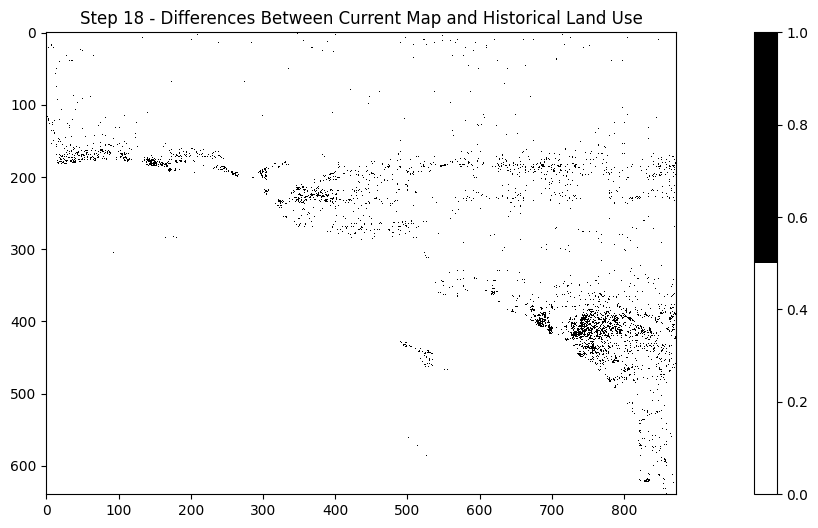

/home/limingl/wildfire/CA_model/Output_10/Fire_map/Fire_2018.csv
/home/limingl/wildfire/CA_model/Output_10/Historical_Land_Use/Historical_land_2019.csv
Step 19: Number of different positions historical--predict: 5459
Step 19: Number of different positions predict--historical: 12780


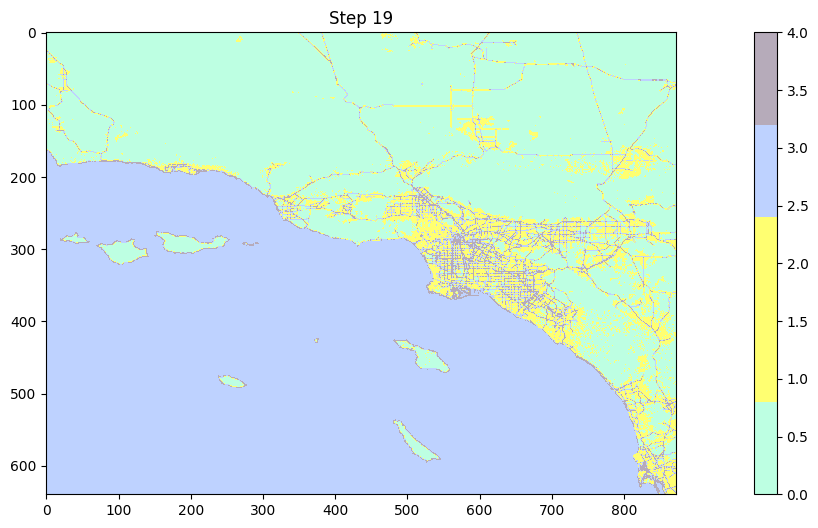

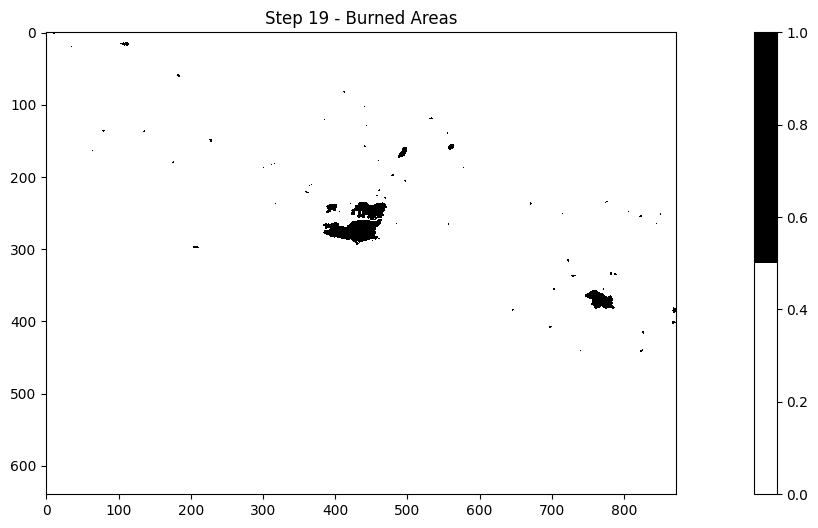

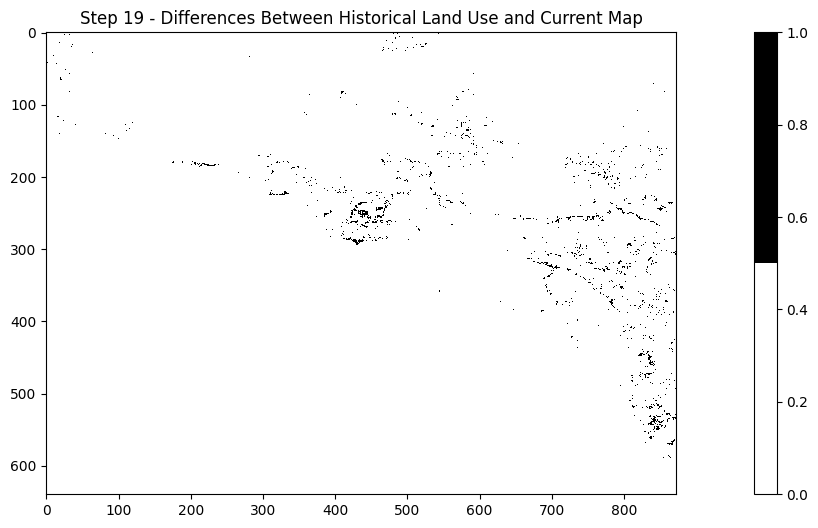

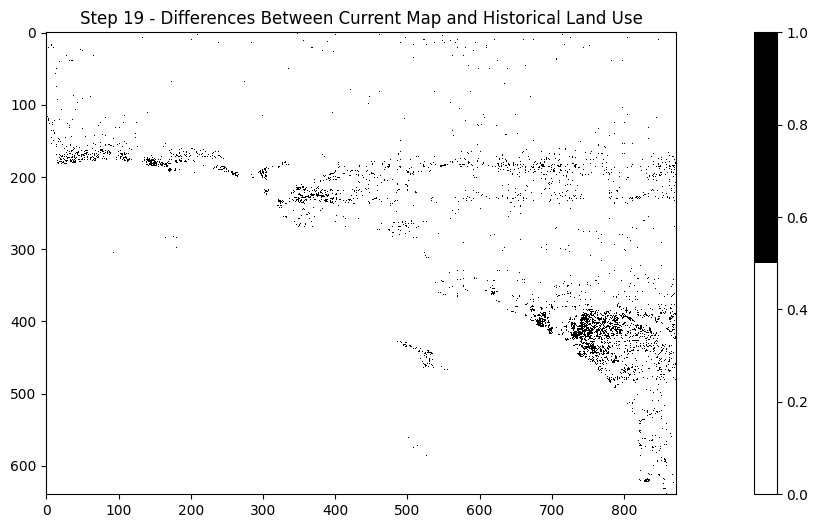

/home/limingl/wildfire/CA_model/Output_10/Fire_map/Fire_2019.csv
/home/limingl/wildfire/CA_model/Output_10/Historical_Land_Use/Historical_land_2020.csv
Step 20: Number of different positions historical--predict: 5635
Step 20: Number of different positions predict--historical: 13408


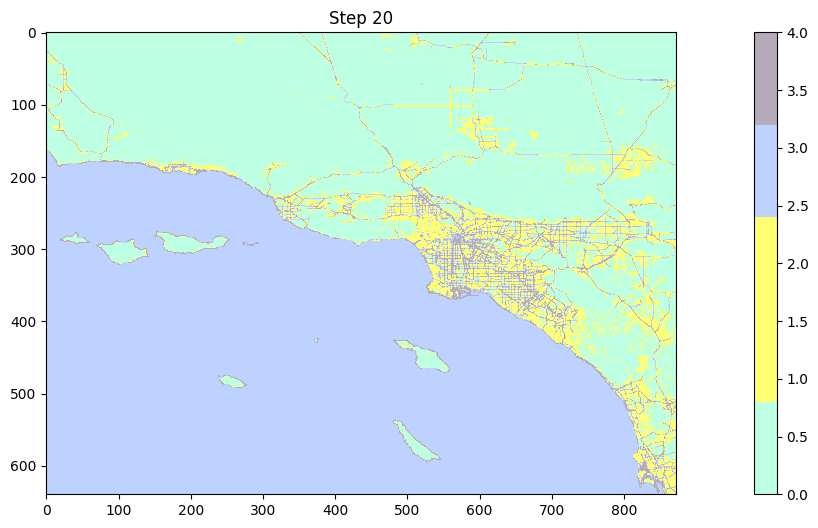

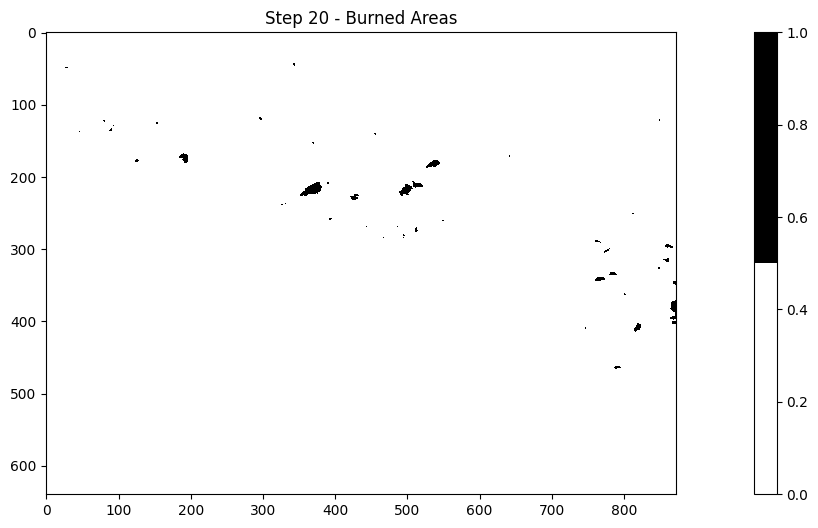

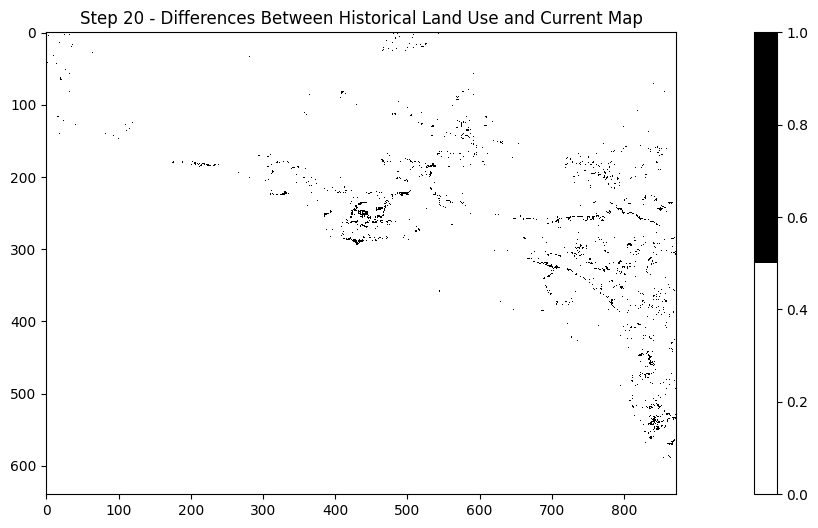

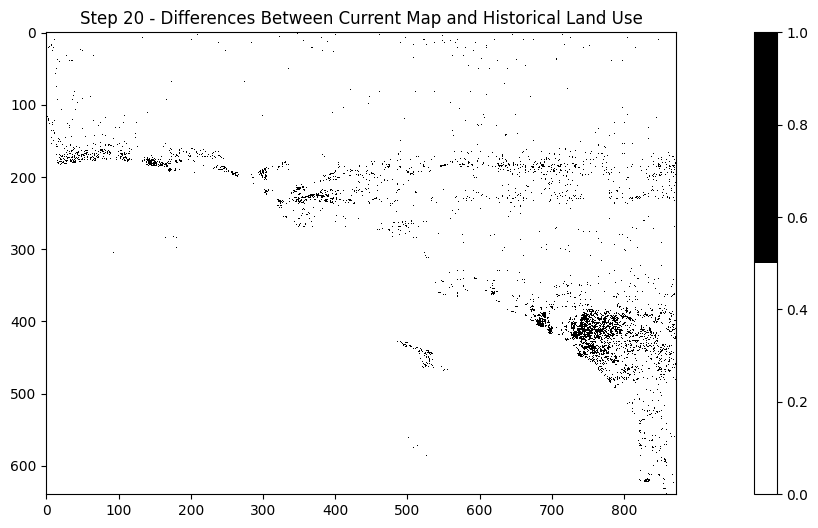

In [6]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import pandas as pd
from land_use_rules_test import land_use_transformation, LAND_UNDEVELOPED, LAND_LOWPRICE, LAND_HIGHPRICE, LAND_FIXED, LAND_ROAD
from random_walk import create_random_walk_demand_map
from Wildfire_Risk_Map import set_radius_6_to_2
from Wildfire_risk import process_matrices
from burned_cells import calculate_burned_cells
from Tolerance import Tolerance_maps
import os

size = (640, 873)
steps = 20

suitability_map = pd.read_csv("/home/limingl/wildfire/CA_model/Suitablity.csv", header=None).values
initial_map = pd.read_csv("/home/limingl/wildfire/CA_model/Initial_final.csv", header=None).values
initial_population_map = pd.read_csv("/home/limingl/wildfire/CA_model/Population_2000.csv", header=None).values
initial_map[initial_map == 5] = 4

matrix1 = pd.read_csv("/home/limingl/wildfire/CA_model/R_highway.csv", header=None).to_numpy()
matrix2 = pd.read_csv("/home/limingl/wildfire/CA_model/R_coastline.csv", header=None).to_numpy()
accessibility_map = (1 + matrix1) * (1 + matrix2)

bimoe_map = pd.read_csv("/home/limingl/wildfire/Biome.csv", header=None).to_numpy()
vegetation_map = pd.read_csv("/home/limingl/wildfire/Vegetation.csv", header=None).to_numpy()
risk_map = pd.read_csv("/home/limingl/wildfire/CA_model/inner_coastline/WUI_Per_matrix.csv", header=None).to_numpy()

colors = {
    LAND_UNDEVELOPED: "#BDFFE2",
    LAND_LOWPRICE: "#FFFF71",
    LAND_HIGHPRICE: "#FFFF71",
    LAND_FIXED: "#BED2FF",
    LAND_ROAD: "#B6ABBA"
}
cmap = ListedColormap([colors[x] for x in [LAND_UNDEVELOPED, LAND_LOWPRICE, LAND_HIGHPRICE, LAND_FIXED, LAND_ROAD]])

relief_cum_map = np.ones((640, 873))
plt.figure(figsize=(20, 6))
plt.imshow(initial_population_map, cmap='hot')  # 使用红热颜色映射
plt.title('Demand Map')
plt.colorbar()
plt.show()
plt.close()

def simulate_land_use(map, population_map, risk_map, steps, size=(640, 873)):
    for step in range(steps):
        
        burned_map_folder = '/home/limingl/wildfire/CA_model/Output_10/Fire_map'
        bill_file = '/home/limingl/wildfire/CA_model/Output_10/Forest_Education.xlsx'
        relief_map_folder = '/home/limingl/wildfire/CA_model/Output_10/Relief_map'
        Historical_map_folder = '/home/limingl/wildfire/CA_model/Output_10/Historical_Land_Use'
        
        A, B, C, D = 8.212, 7.818, 1.749, 2.048
        Tolerance_map = Tolerance_maps(burned_map_folder, bill_file, relief_map_folder, A, B, C, D, step)

        growth_rate_map = create_random_walk_demand_map(size, mean=2.68, std=1.86)
        demand_map = population_map * (1 + growth_rate_map) * Tolerance_map
        
        mask_compare = (risk_map == 1) | (risk_map == 2)
        mask_nonzero_new_map = map != 0
        risk_map[mask_compare & mask_nonzero_new_map] = 0
        risk_map = set_radius_6_to_2(risk_map)

        new_map, Vi_matrix = land_use_transformation(map, suitability_map, accessibility_map, demand_map)
        new_map[map == LAND_ROAD] = LAND_ROAD

        burned_map_files = sorted([
            f for f in os.listdir(burned_map_folder) 
            if os.path.isfile(os.path.join(burned_map_folder, f))
        ])
        burned_map_file = burned_map_files[step]
        burned_map_path = os.path.join(burned_map_folder, burned_map_file)
        print(burned_map_path)
        Wildfire_risk = pd.read_csv(burned_map_path, header=None).values
        new_map, burned_map = calculate_burned_cells(Wildfire_risk, new_map)

        population_map = demand_map  
        population_map[burned_map] = 0.01
        map = new_map

        Historical_map_files = sorted([
            f for f in os.listdir(Historical_map_folder) 
            if os.path.isfile(os.path.join(Historical_map_folder, f))
        ])
        Historical_map_file = Historical_map_files[step]
        Historical_map_path = os.path.join(Historical_map_folder, Historical_map_file)
        print(Historical_map_path)
        Historical_land_use = pd.read_csv(Historical_map_path, header=None).values
        
        differences = ((Historical_land_use == 1) | (Historical_land_use == 2)) & (map == 0)
        
        num_different_positions = np.sum(differences)
        print(f"Step {step + 1}: Number of different positions historical--predict: {num_different_positions}")

        differences_1 = ((map == 1) | (map == 2)) & (Historical_land_use == 0)
        
        num_different_positions_1 = np.sum(differences_1)
        print(f"Step {step + 1}: Number of different positions predict--historical: {num_different_positions_1}")

        # Visualization
        cmap_difference = ListedColormap(['white', 'black'])

        plt.figure(figsize=(20, 6))
        plt.imshow(map, cmap=cmap)
        plt.title(f'Step {step + 1}')
        plt.colorbar()
        plt.show()
        plt.close()

        cmap1 = ListedColormap(['white', 'black'])
        
        plt.figure(figsize=(20, 6))
        plt.imshow(burned_map, cmap=cmap1, vmin=0, vmax=1)
        plt.title(f'Step {step + 1} - Burned Areas')
        plt.colorbar()
        plt.show()
        plt.close()

        plt.figure(figsize=(20, 6))
        plt.imshow(differences, cmap=cmap_difference, vmin=0, vmax=1)
        plt.title(f'Step {step + 1} - Differences Between Historical Land Use and Current Map')
        plt.colorbar()
        plt.show()
        plt.close()

        plt.figure(figsize=(20, 6))
        plt.imshow(differences_1, cmap=cmap_difference, vmin=0, vmax=1)
        plt.title(f'Step {step + 1} - Differences Between Current Map and Historical Land Use')
        plt.colorbar()
        plt.show()
        plt.close()

        #plt.figure(figsize=(20, 6))
        #img = plt.imshow(Vi_matrix, cmap='viridis')
        #
        #cbar = plt.colorbar(img, ticks=[Vi_matrix.min(), Vi_matrix.max()])
        #cbar.set_ticklabels(['Low', 'High'])
        #plt.show()
        #plt.close()

    return map

np.random.seed(2)
final_map = simulate_land_use(initial_map, initial_population_map, risk_map, steps)